## Problem Statement

The data used for this exercise is of company XYZ, with about 4000 employees, spread over 5 different csv files. The goal is to analyse the factors contributing to employee attrition (ie employees leaving, either on their own or because they got fired).


## Import packages

In [1]:
options(warn=-1)

In [2]:
install.packages("ROSE")

package 'ROSE' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\urvi3\AppData\Local\Temp\RtmpI1VMFR\downloaded_packages


In [3]:
library(e1071)
library(ggplot2)
library(cowplot)
library(caTools)
library(lubridate)
library(ROCR)
library(ROSE)
library(Hmisc)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'lubridate'

The following object is masked from 'package:cowplot':

    stamp

The following object is masked from 'package:base':

    date

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Loaded ROSE 0.0-3

Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following object is masked from 'package:e1071':

    impute

The following objects are masked from 'package:base':

    format.pval, units



## Read data

In [4]:
#reading all the CSV files and converting to data frame 
emp_general<-read.csv("general_data.csv", stringsAsFactors = F)
emp_suvey<-read.csv("employee_survey_data.csv",stringsAsFactors = F)
emp_manager_suvey<-read.csv("manager_survey_data.csv",stringsAsFactors = F)
emp_intime<-read.csv("in_time.csv",stringsAsFactors = F)
emp_outime<-read.csv("out_time.csv",stringsAsFactors = F)

## Explore data

In [5]:
str(emp_general) #4410 obs. of  24 variables with target variable "Attrition"

'data.frame':	4410 obs. of  24 variables:
 $ Age                    : int  51 31 32 38 32 46 28 29 31 25 ...
 $ Attrition              : chr  "No" "Yes" "No" "No" ...
 $ BusinessTravel         : chr  "Travel_Rarely" "Travel_Frequently" "Travel_Frequently" "Non-Travel" ...
 $ Department             : chr  "Sales" "Research & Development" "Research & Development" "Research & Development" ...
 $ DistanceFromHome       : int  6 10 17 2 10 8 11 18 1 7 ...
 $ Education              : int  2 1 4 5 1 3 2 3 3 4 ...
 $ EducationField         : chr  "Life Sciences" "Life Sciences" "Other" "Life Sciences" ...
 $ EmployeeCount          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeID             : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Gender                 : chr  "Female" "Female" "Male" "Male" ...
 $ JobLevel               : int  1 1 4 3 1 4 2 2 3 4 ...
 $ JobRole                : chr  "Healthcare Representative" "Research Scientist" "Sales Executive" "Human Resources" ...
 $ MaritalStatus          : chr 

In [6]:
str(emp_suvey)   #4410 obs. of  4 variables

'data.frame':	4410 obs. of  4 variables:
 $ EmployeeID             : int  1 2 3 4 5 6 7 8 9 10 ...
 $ EnvironmentSatisfaction: int  3 3 2 4 4 3 1 1 2 2 ...
 $ JobSatisfaction        : int  4 2 2 4 1 2 3 2 4 1 ...
 $ WorkLifeBalance        : int  2 4 1 3 3 2 1 3 3 3 ...


In [7]:
str(emp_manager_suvey) #4410 obs. of  3 variables

'data.frame':	4410 obs. of  3 variables:
 $ EmployeeID       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ JobInvolvement   : int  3 2 3 2 3 3 3 3 3 3 ...
 $ PerformanceRating: int  3 4 3 3 3 3 4 4 4 3 ...


In [8]:
#Adding first column header in both the dataframes
colnames(emp_intime)[1]<-"EmployeeID"
colnames(emp_outime)[1]<-"EmployeeID"

In [9]:
setdiff(emp_general$EmployeeID,emp_suvey$EmployeeID)  #Identical EmployeeID across these datasets
setdiff(emp_general$EmployeeID,emp_manager_suvey$EmployeeID) #Identical EmployeeID across these datasets
setdiff(emp_general$EmployeeID,emp_intime$EmployeeID)   #Identical EmployeeID across these datasets
setdiff(emp_general$EmployeeID,emp_outime$EmployeeID)   #Identical EmployeeID across these datasets

integer(0)

integer(0)

integer(0)

integer(0)

## Data preprocessing - 1

Working with time_in and time_out dataframes for data transformation and cleaning

In [10]:
#Converting columns into appropriate date & time format
emp_id<-emp_intime[1]
emp_intime <- as.data.frame(lapply( emp_intime[, -1], as.POSIXlt))
emp_outime <- as.data.frame(lapply( emp_outime[, -1], as.POSIXlt))

In [11]:
#Comparing the column headers in both the dataframes
setdiff(colnames(emp_intime), colnames(emp_outime)) #As all the coulms are same so substracting both the dataframes

character(0)

In [12]:
#calculating difference of times to get actual login hours
emp_login <-  emp_outime-emp_intime

In [13]:
#Converting login hours to 2 decimal points
emp_login <- as.data.frame(lapply(emp_login, round, digits=2))

In [14]:
#To delete all such columns when everybody was NA's as those are company holidays. 
emp_login <- emp_login[,colSums(is.na(emp_login))<nrow(emp_login)]
emp_login<-cbind(emp_id,emp_login)

In [15]:
#Converting all the columns into numeric
emp_login<- as.data.frame(sapply(emp_login, as.numeric))

## Derived Metrics

3 additional input features have been created using time_in and time_out dataframes

In [16]:
#To calculate average login hours for the employee
emp_login$emp_avg_login <- apply(emp_login[,-1], 1, mean, na.rm=TRUE)

In [17]:
#round off the average working hours
emp_login$emp_avg_login<-round(emp_login$emp_avg_login, 0)

In [18]:
#Bucketing the avg login time into 3 categories by considering standard login hours as 8
emp_login$emp_login_cat<- ifelse(emp_login$emp_avg_login > 8, "overtime", ifelse(emp_login$emp_avg_login>7 & emp_login$emp_avg_login<=8,"regular", "early logout"))

In [19]:
#extrating only 3 columns to merge with other dataset's
emp_login<-emp_login[, c(1,251,252)]

In [20]:
#Merging all the dataset and creating master dataframe as "hrdata"
hrdata<-merge(emp_general,emp_suvey, by="EmployeeID", all = F)
hrdata<- merge(hrdata,emp_manager_suvey, by="EmployeeID", all = F)
hrdata<- merge(hrdata,emp_login, by="EmployeeID", all = F)

In [21]:
str(hrdata)

'data.frame':	4410 obs. of  31 variables:
 $ EmployeeID             : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Age                    : int  51 31 32 38 32 46 28 29 31 25 ...
 $ Attrition              : chr  "No" "Yes" "No" "No" ...
 $ BusinessTravel         : chr  "Travel_Rarely" "Travel_Frequently" "Travel_Frequently" "Non-Travel" ...
 $ Department             : chr  "Sales" "Research & Development" "Research & Development" "Research & Development" ...
 $ DistanceFromHome       : int  6 10 17 2 10 8 11 18 1 7 ...
 $ Education              : int  2 1 4 5 1 3 2 3 3 4 ...
 $ EducationField         : chr  "Life Sciences" "Life Sciences" "Other" "Life Sciences" ...
 $ EmployeeCount          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Gender                 : chr  "Female" "Female" "Male" "Male" ...
 $ JobLevel               : int  1 1 4 3 1 4 2 2 3 4 ...
 $ JobRole                : chr  "Healthcare Representative" "Research Scientist" "Sales Executive" "Human Resources" ...
 $ MaritalStatus          : chr 

In [22]:
#removing columns which are having only single type value
hrdata<-hrdata[, -c(9,16,18)]

## Under Sampling 

In [23]:
sum(is.na(hrdata))

[1] 111

We have 111 NA values in the dataframe.

In [24]:
table(hrdata$Attrition)


  No  Yes 
3699  711 

This is a higly imbalanced dataset with close to 15.7% attrition rate.

In [25]:
hrdata <- ovun.sample(Attrition ~ ., data = hrdata, method = "under", N = 1500, seed = 1)$data
table(hrdata$Attrition)


 No Yes 
805 695 

In [26]:
str(hrdata)

'data.frame':	1500 obs. of  28 variables:
 $ EmployeeID             : int  1254 844 2671 1150 1877 591 2874 330 1487 4134 ...
 $ Age                    : int  27 32 35 24 36 35 27 52 21 38 ...
 $ Attrition              : chr  "No" "No" "No" "No" ...
 $ BusinessTravel         : chr  "Travel_Rarely" "Travel_Rarely" "Travel_Rarely" "Travel_Rarely" ...
 $ Department             : chr  "Sales" "Research & Development" "Human Resources" "Research & Development" ...
 $ DistanceFromHome       : int  8 22 14 5 26 3 15 29 3 23 ...
 $ Education              : int  2 4 1 4 4 3 3 3 2 3 ...
 $ EducationField         : chr  "Marketing" "Medical" "Life Sciences" "Other" ...
 $ Gender                 : chr  "Female" "Male" "Male" "Male" ...
 $ JobLevel               : int  3 1 2 1 1 2 1 2 1 3 ...
 $ JobRole                : chr  "Research Scientist" "Sales Executive" "Research Scientist" "Manufacturing Director" ...
 $ MaritalStatus          : chr  "Divorced" "Married" "Married" "Single" ...
 $ Monthly

In [27]:
sum(is.na(hrdata))

[1] 0

We are left with no null values after undersampling.

## Variable Transformation

As per data dictionary, bringing few variables into correct format by converting the numeric values to categorical variables

In [28]:
hrdata$Education[which(hrdata$Education==1)]<-'Below College'
hrdata$Education[which(hrdata$Education==2)]<-'College'
hrdata$Education[which(hrdata$Education==3)]<-'Bachelor'
hrdata$Education[which(hrdata$Education==4)]<-'Master'
hrdata$Education[which(hrdata$Education==5)]<-'Doctor'
hrdata$EnvironmentSatisfaction[which(hrdata$EnvironmentSatisfaction==1)]<-'Low'
hrdata$EnvironmentSatisfaction[which(hrdata$EnvironmentSatisfaction==2)]<-'Medium'
hrdata$EnvironmentSatisfaction[which(hrdata$EnvironmentSatisfaction==3)]<-'High'
hrdata$EnvironmentSatisfaction[which(hrdata$EnvironmentSatisfaction==4)]<-'Very High'
hrdata$JobInvolvement[which(hrdata$JobInvolvement==1)]<-'Low'
hrdata$JobInvolvement[which(hrdata$JobInvolvement==2)]<-'Medium'
hrdata$JobInvolvement[which(hrdata$JobInvolvement==3)]<-'High'
hrdata$JobInvolvement[which(hrdata$JobInvolvement==4)]<-'Very High'
hrdata$JobSatisfaction[which(hrdata$JobSatisfaction==1)]<-'Low'
hrdata$JobSatisfaction[which(hrdata$JobSatisfaction==2)]<-'Medium'
hrdata$JobSatisfaction[which(hrdata$JobSatisfaction==3)]<-'High'
hrdata$JobSatisfaction[which(hrdata$JobSatisfaction==4)]<-'Very High'
hrdata$WorkLifeBalance[which(hrdata$WorkLifeBalance==1)]<-'Bad'
hrdata$WorkLifeBalance[which(hrdata$WorkLifeBalance==2)]<-'Good'
hrdata$WorkLifeBalance[which(hrdata$WorkLifeBalance==3)]<-'Better'
hrdata$WorkLifeBalance[which(hrdata$WorkLifeBalance==4)]<-'Best'
hrdata$PerformanceRating[which(hrdata$PerformanceRating==1)]<-'Low'
hrdata$PerformanceRating[which(hrdata$PerformanceRating==2)]<-'Good'
hrdata$PerformanceRating[which(hrdata$PerformanceRating==3)]<-'Excellent'
hrdata$PerformanceRating[which(hrdata$PerformanceRating==4)]<-'Outstanding'

## Bi-Variate Analysis

### Categorical Data

We make barcharts to analyse input variables wrt Attrition.

In [29]:
# Barcharts for categorical features with stacked Attrition information
bar_theme1<- theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), legend.position="none")

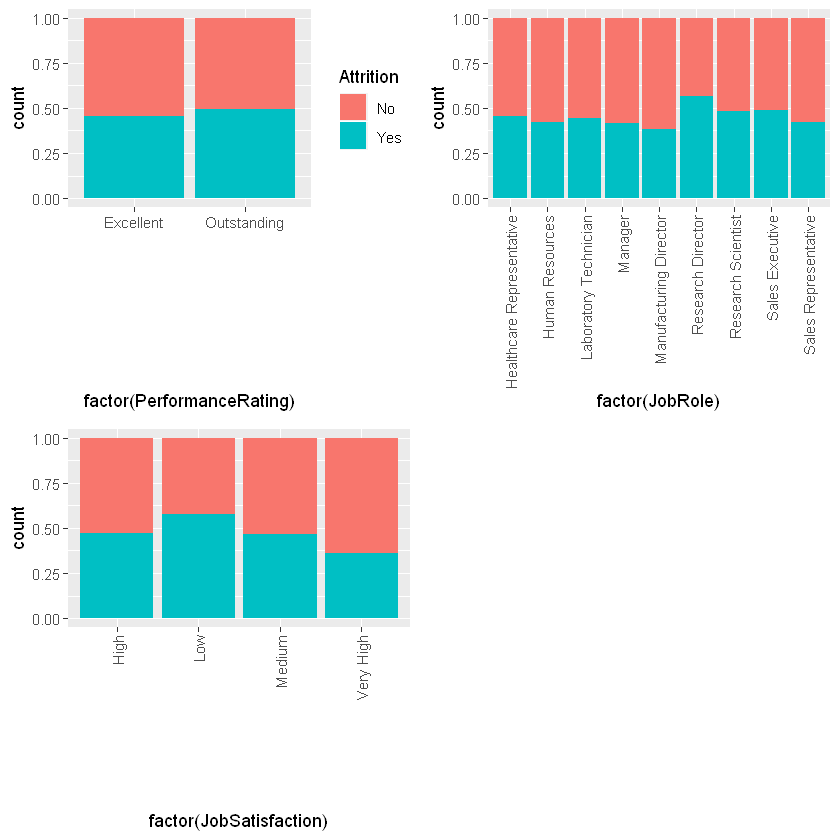

In [30]:
plot_grid(ggplot(hrdata, aes(x=factor(PerformanceRating),fill=Attrition))+ geom_bar(position ="fill"),ggplot(hrdata, aes(x=factor(JobRole),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,ggplot(hrdata, aes(x=factor(JobSatisfaction),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1, align = "h") 

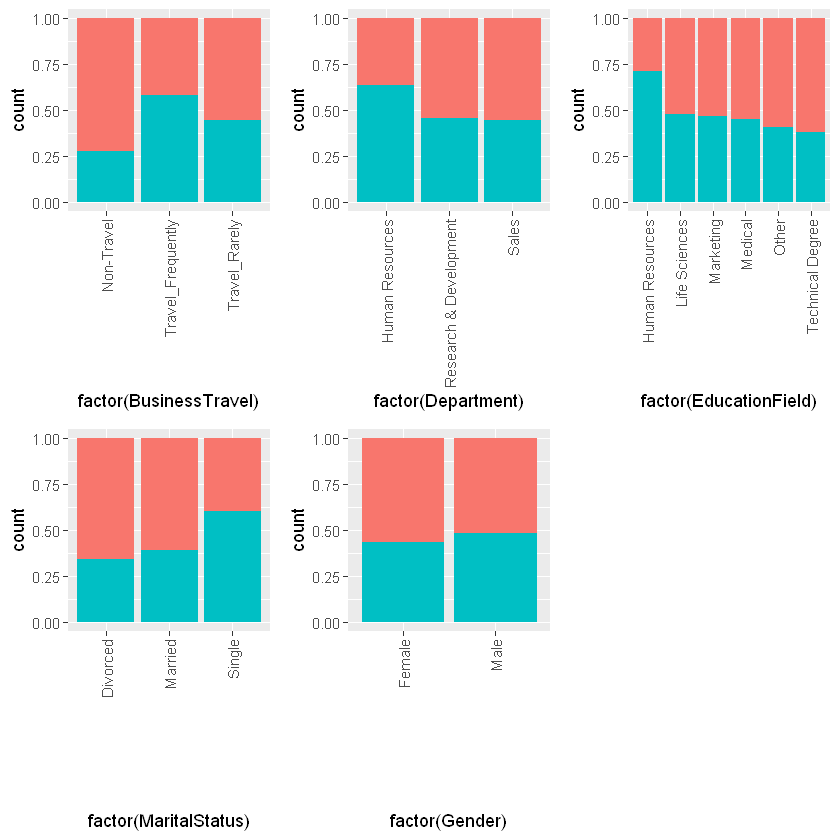

In [31]:
plot_grid(ggplot(hrdata, aes(x=factor(BusinessTravel),fill=Attrition))+ geom_bar(position ="fill") + bar_theme1,ggplot(hrdata, aes(x=factor(Department),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,ggplot(hrdata, aes(x=factor(EducationField),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,ggplot(hrdata, aes(x=factor(MaritalStatus),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,ggplot(hrdata, aes(x=factor(Gender),fill=Attrition))+ geom_bar(position ="fill")+ bar_theme1, align = "h") 

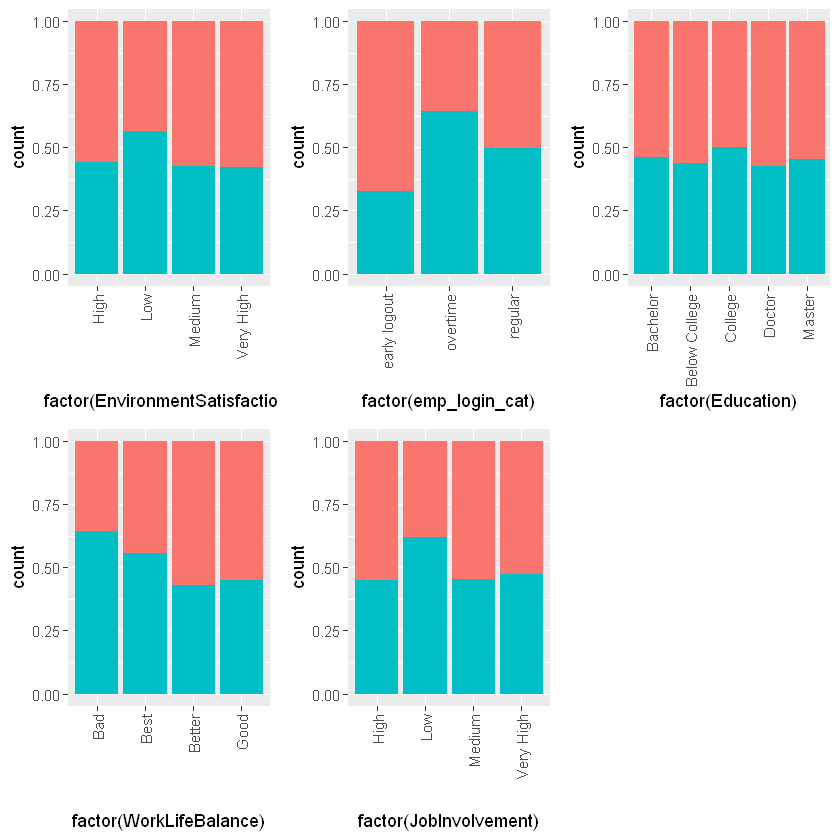

In [32]:
plot_grid(ggplot(hrdata, aes(x=factor(EnvironmentSatisfaction),fill=Attrition))+ geom_bar(position ="fill")+ bar_theme1, ggplot(hrdata, aes(x=factor(emp_login_cat),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,ggplot(hrdata, aes(x=factor(Education),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,ggplot(hrdata, aes(x=factor(WorkLifeBalance),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,ggplot(hrdata, aes(x=factor(JobInvolvement),fill=Attrition))+ geom_bar(position ="fill")+bar_theme1,align = "h") 


**Conclusion:**

    If job involvement is low there is attrition.
    If workbalancelife is bad there is attrition.
    Low env. satisfaction causes attrition.
    Also low job satisfaction causes attrition according to the graphs.
    In performance rating, attrition is high on outstanding column.
    In business travel, attrition is high on travel frequently column.
    In department, there is a problem in hr.
    In education, college column has the higher attrition.
    In education field, attrition is high on human resources column.
    In gender, male has the highest attirtion.
    In job role, research direct. has the higest attrition.
    In marital, single column has the highest attrition.
    Employees who do overtime show very high attrition.

### Numeric Data

We make density plots to analyse these.

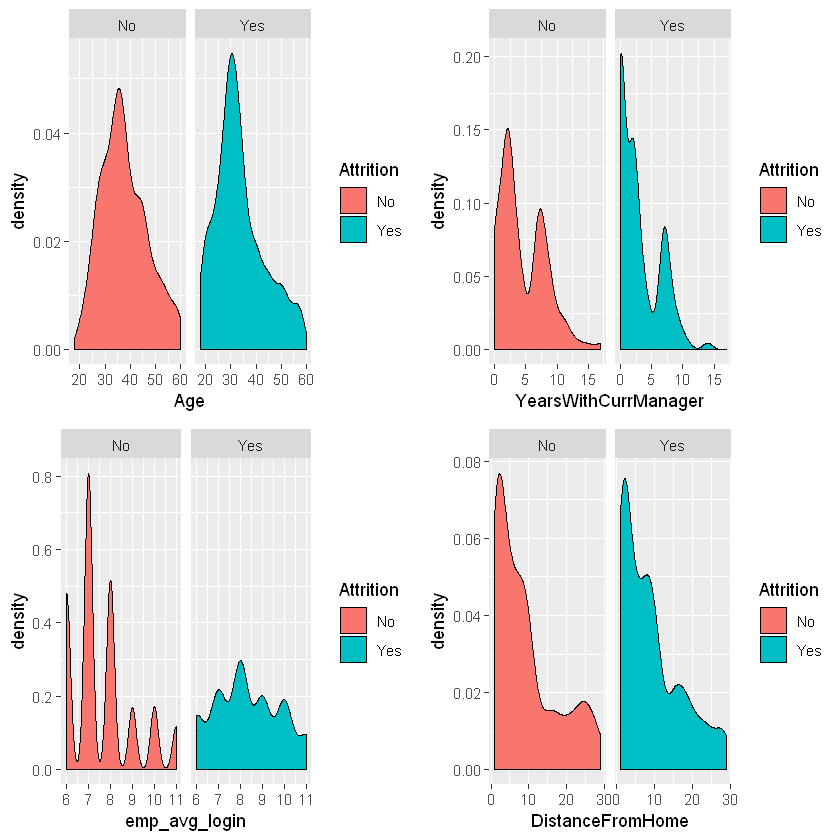

In [33]:
plot_grid(ggplot(hrdata,aes(Age,fill=Attrition))+geom_density()+facet_grid(~Attrition), ggplot(hrdata,aes(YearsWithCurrManager,fill=Attrition))+geom_density()+facet_grid(~Attrition),ggplot(hrdata,aes(emp_avg_login,fill=Attrition))+geom_density()+facet_grid(~Attrition),ggplot(hrdata,aes(DistanceFromHome,fill=Attrition))+geom_density()+facet_grid(~Attrition), align='h')

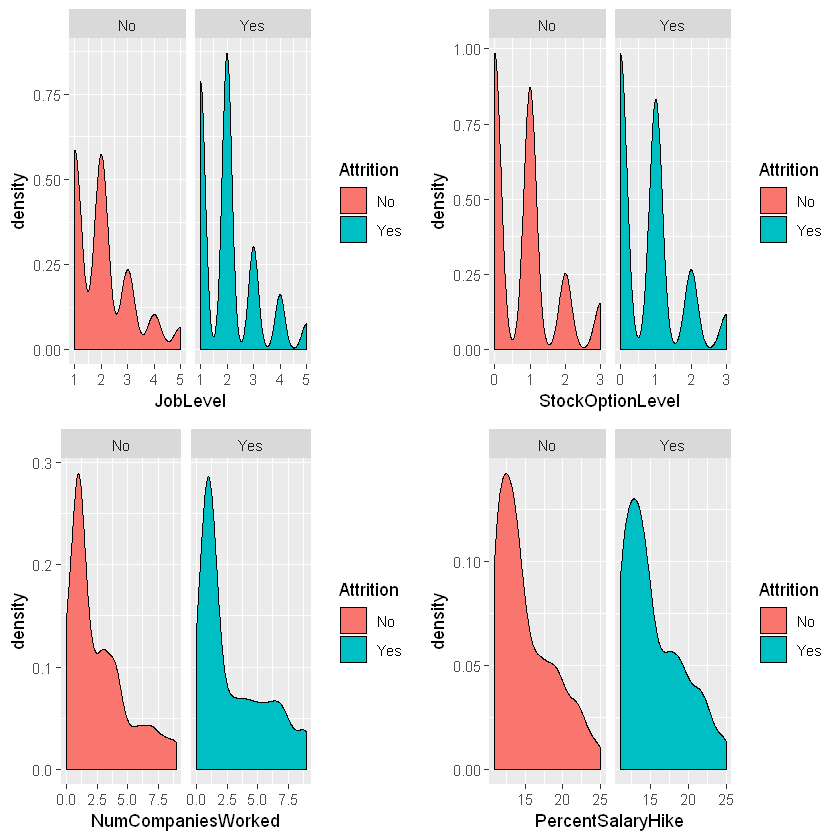

In [34]:
plot_grid(ggplot(hrdata,aes(JobLevel,fill=Attrition))+geom_density()+facet_grid(~Attrition), ggplot(hrdata,aes(StockOptionLevel,fill=Attrition))+geom_density()+facet_grid(~Attrition),ggplot(hrdata,aes(NumCompaniesWorked,fill=Attrition))+geom_density()+facet_grid(~Attrition),ggplot(hrdata,aes(PercentSalaryHike,fill=Attrition))+geom_density()+facet_grid(~Attrition), align='h')

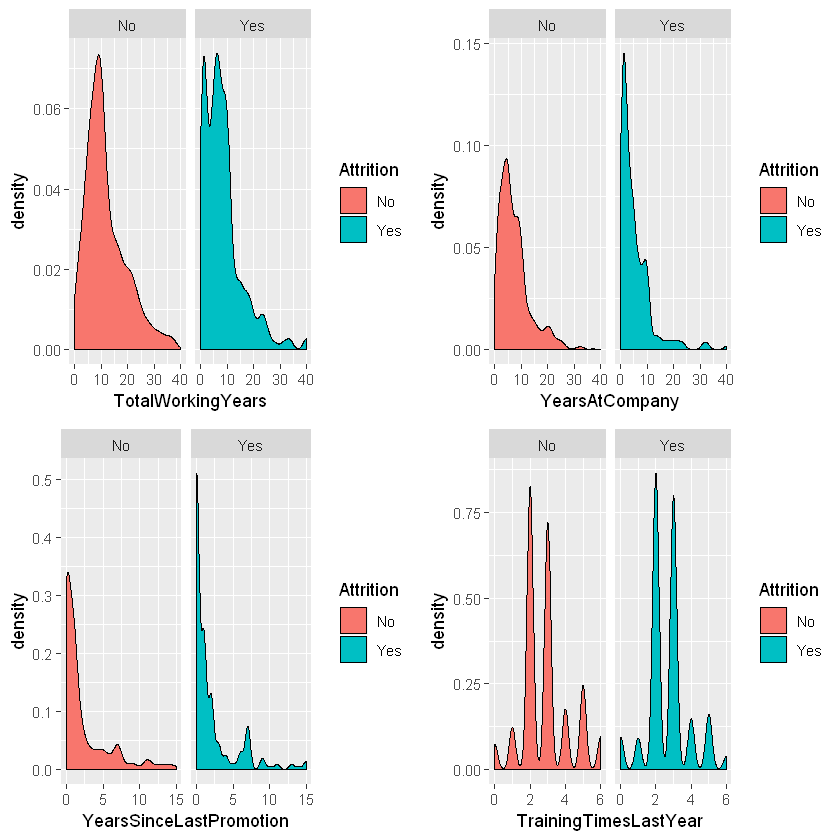

In [35]:
plot_grid(ggplot(hrdata,aes(TotalWorkingYears,fill=Attrition))+geom_density()+facet_grid(~Attrition), ggplot(hrdata,aes(YearsAtCompany,fill=Attrition))+geom_density()+facet_grid(~Attrition),ggplot(hrdata,aes(YearsSinceLastPromotion,fill=Attrition))+geom_density()+facet_grid(~Attrition),ggplot(hrdata,aes(TrainingTimesLastYear,fill=Attrition))+geom_density()+facet_grid(~Attrition), align='h')

**Conclusion:**

  
    We can see that younger people leave often compared to old people.
    High age people are less likely to leave.
    Employees which working less than 8 hours are more likely to stay in the company.
    People new to their managers leave easily.
    Those with Job Levels 1 and 2 ie low ranking jobs tend to leave easily.
    Those with Stock Option Level 0 or 1 ie minimal or no stocks leave often.
    People who have worked at less than 2 companies are more likely to quit.
    So are those salary hike in the last year has been low.
    Those who have been working for less than 10 years have high attrition rate.
    Also, people who are new to the company tend to leave quicker.



## Uni-Variate Analysis

We plot bar graphs to analyse these

### Categorical Data

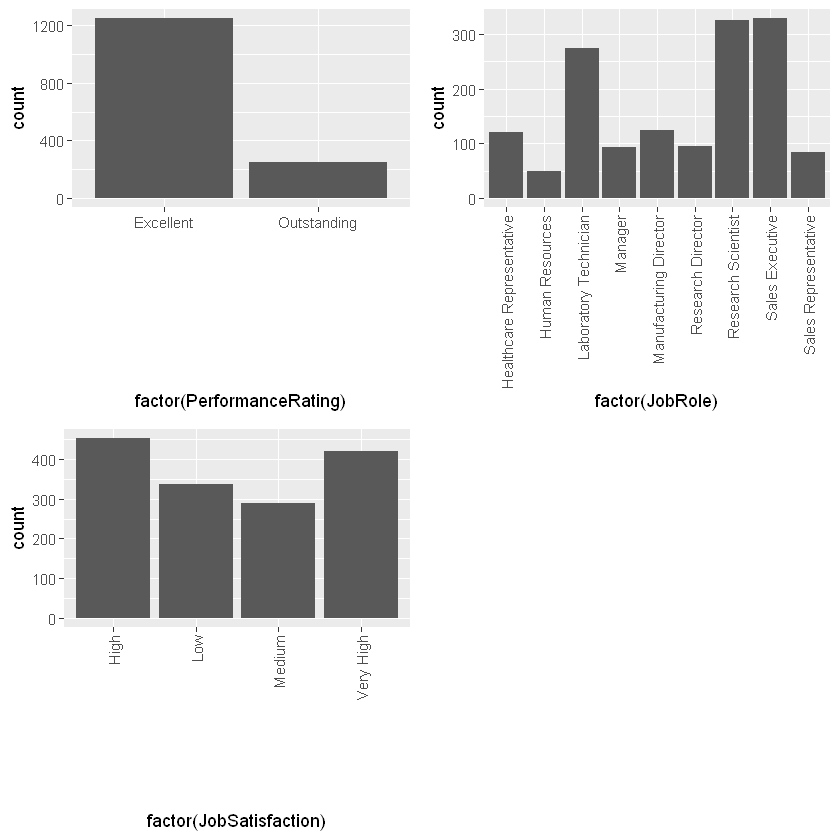

In [36]:
plot_grid(ggplot(hrdata, aes(x=factor(PerformanceRating)))+ geom_bar(),ggplot(hrdata, aes(x=factor(JobRole)))+ geom_bar()+bar_theme1,ggplot(hrdata, aes(x=factor(JobSatisfaction)))+ geom_bar()+bar_theme1, align = "h") 

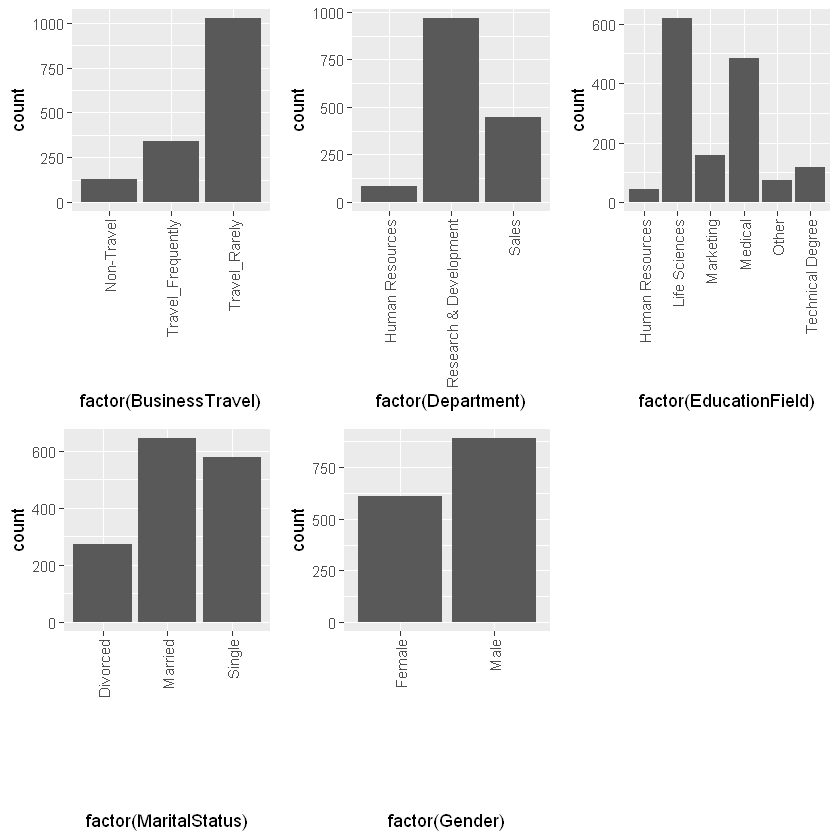

In [37]:
plot_grid(ggplot(hrdata, aes(x=factor(BusinessTravel)))+ geom_bar() + bar_theme1,ggplot(hrdata, aes(x=factor(Department)))+ geom_bar()+bar_theme1,ggplot(hrdata, aes(x=factor(EducationField)))+ geom_bar()+bar_theme1,ggplot(hrdata, aes(x=factor(MaritalStatus)))+ geom_bar()+bar_theme1,ggplot(hrdata, aes(x=factor(Gender)))+ geom_bar()+ bar_theme1, align = "h") 

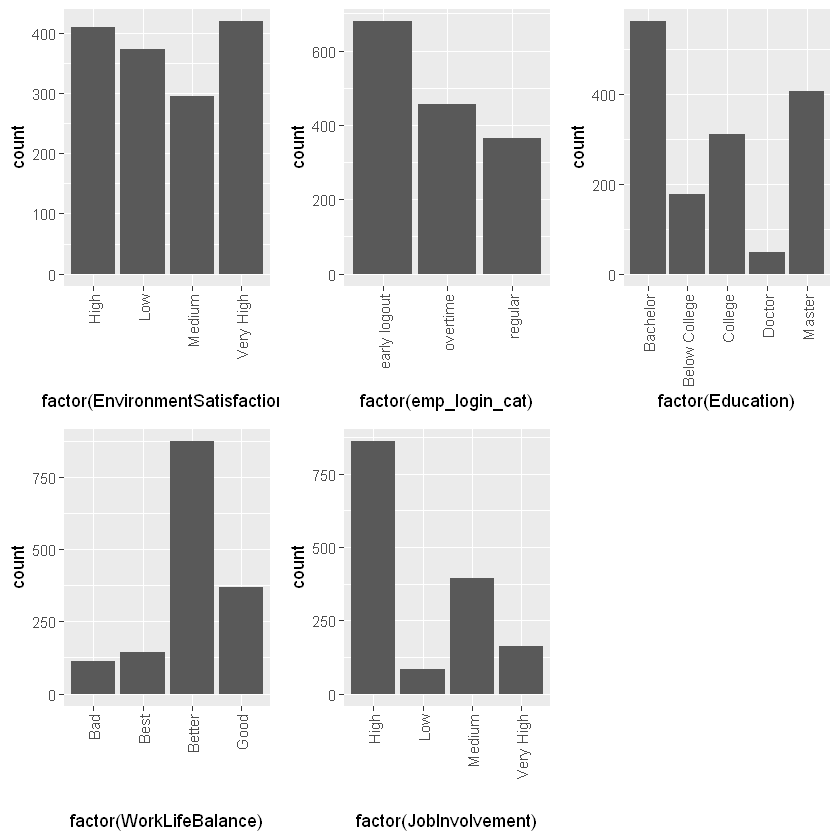

In [38]:
plot_grid(ggplot(hrdata, aes(x=factor(EnvironmentSatisfaction)))+ geom_bar()+ bar_theme1, ggplot(hrdata, aes(x=factor(emp_login_cat)))+ geom_bar()+bar_theme1,ggplot(hrdata, aes(x=factor(Education)))+ geom_bar()+bar_theme1,ggplot(hrdata, aes(x=factor(WorkLifeBalance)))+ geom_bar()+bar_theme1,ggplot(hrdata, aes(x=factor(JobInvolvement)))+ geom_bar()+bar_theme1,align = "h") 

### Numeric Data

We make histogram and boxplots for these.

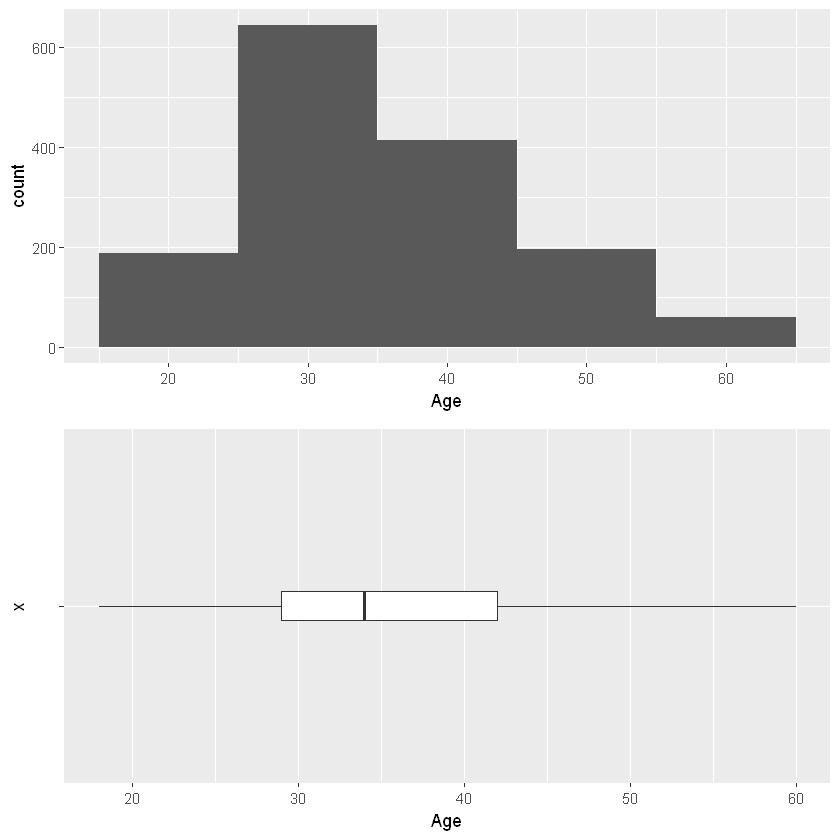

In [39]:
plot_grid(ggplot(hrdata, aes(Age))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=Age))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)


No outliers in Age variable

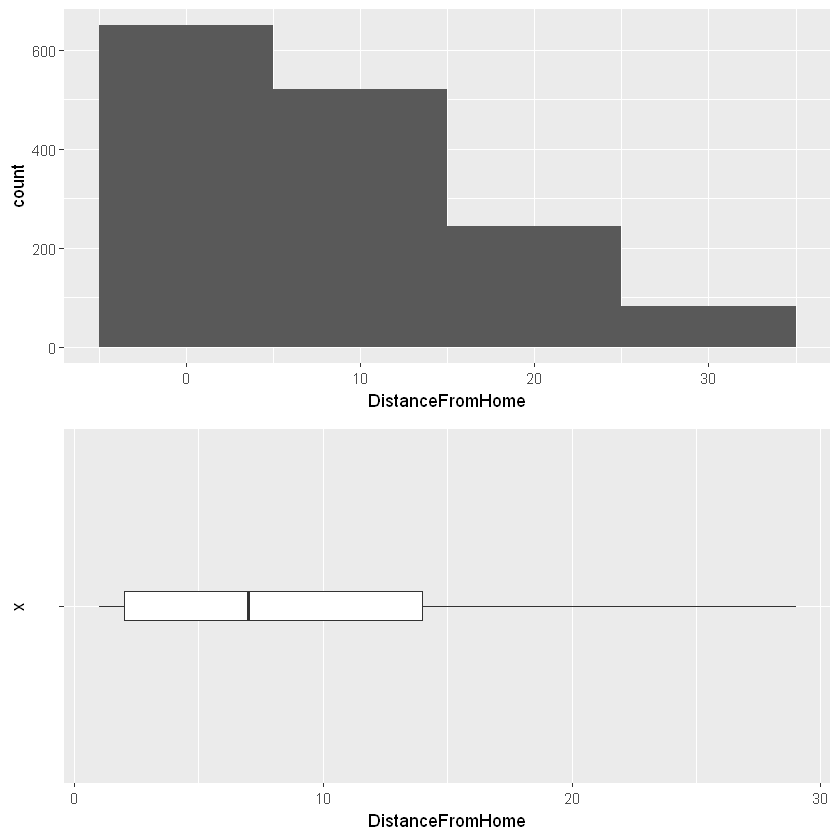

In [40]:
plot_grid(ggplot(hrdata, aes(DistanceFromHome))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=DistanceFromHome))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

No outliers in "DistanceFromHome" variable

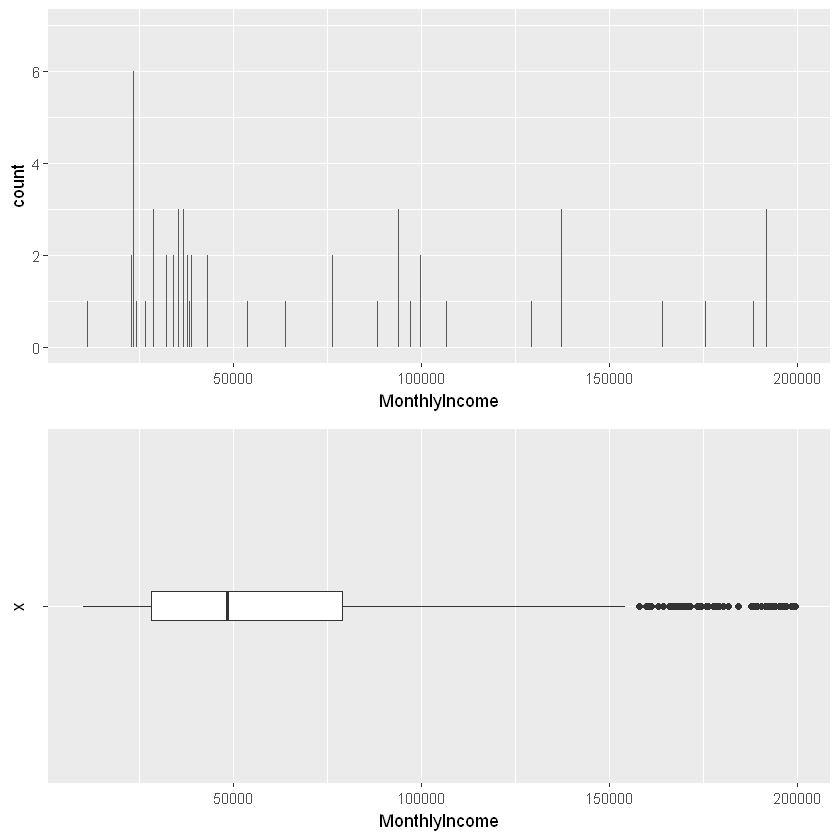

In [41]:
plot_grid(ggplot(hrdata, aes(MonthlyIncome))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=MonthlyIncome))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

Although there is a gradual increase in salary but outlier is available 

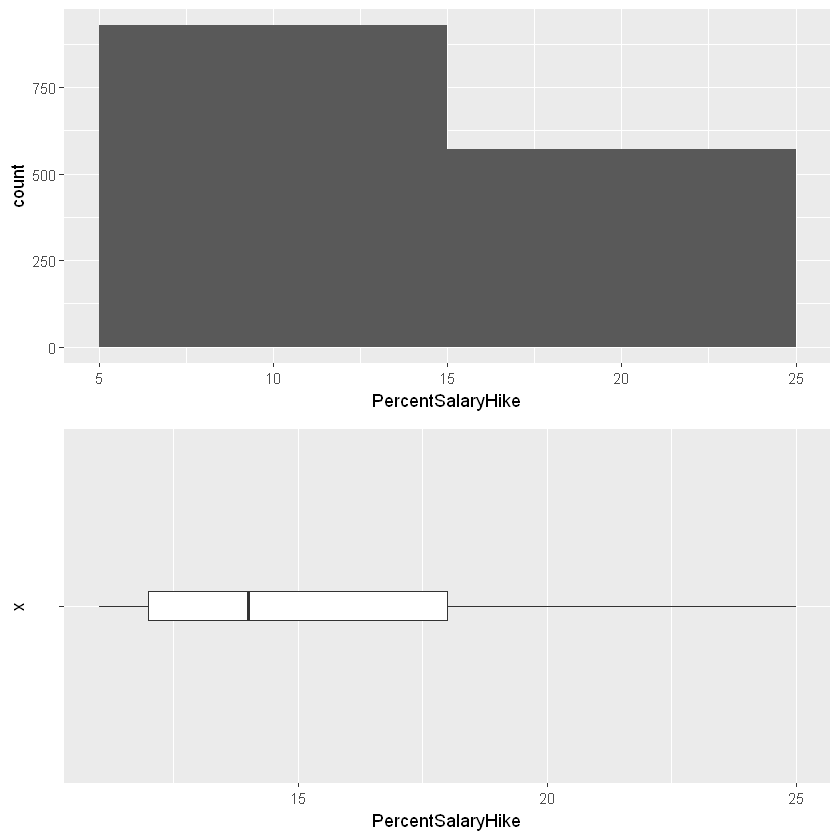

In [42]:
plot_grid(ggplot(hrdata, aes(PercentSalaryHike))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=PercentSalaryHike))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

No outliers in "PercentSalaryHike" variable

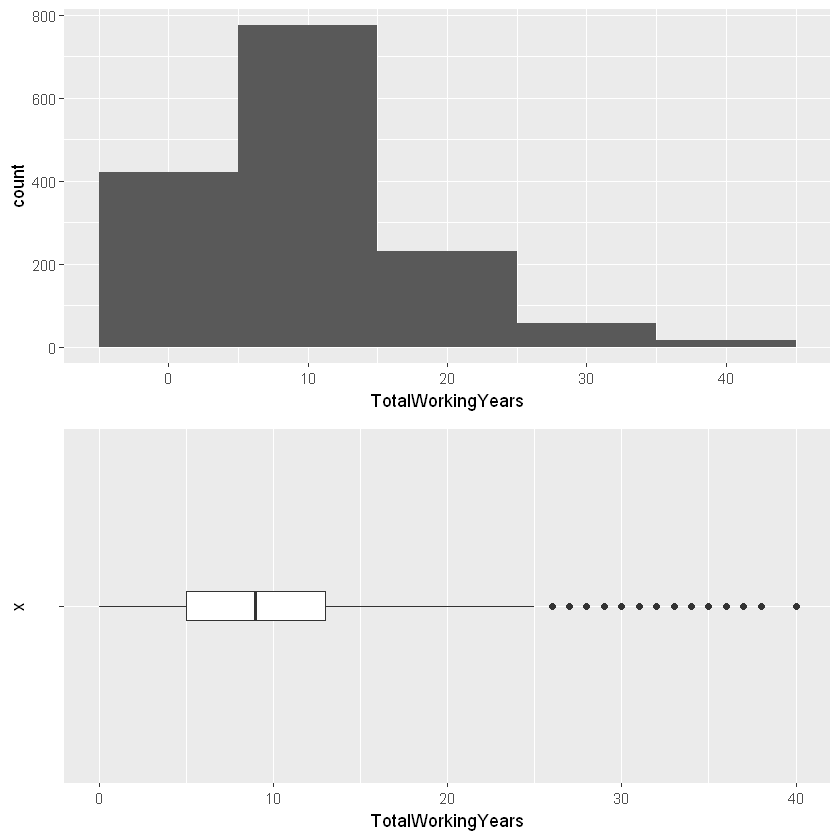

In [43]:
plot_grid(ggplot(hrdata, aes(TotalWorkingYears))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=TotalWorkingYears))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

Outliers can be seen in boxplot for TotalWorkingYears

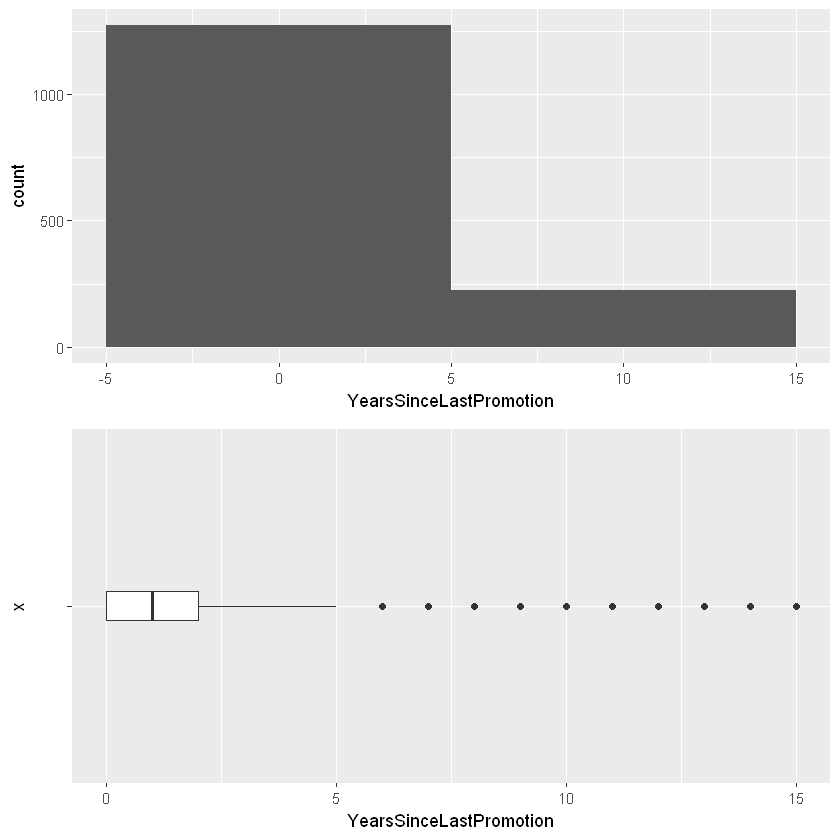

In [44]:
plot_grid(ggplot(hrdata, aes(YearsSinceLastPromotion))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=YearsSinceLastPromotion))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

Outliers can be seen in boxplot for YearsSinceLastPromotion

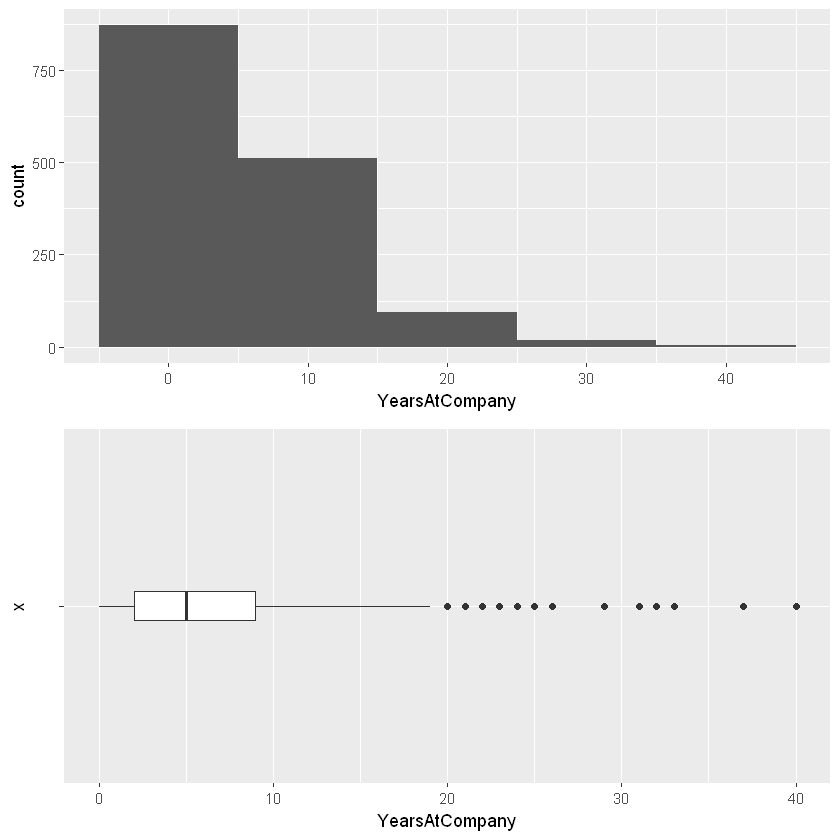

In [45]:
plot_grid(ggplot(hrdata, aes(YearsAtCompany))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=YearsAtCompany))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

Outliers can be seen in boxplot

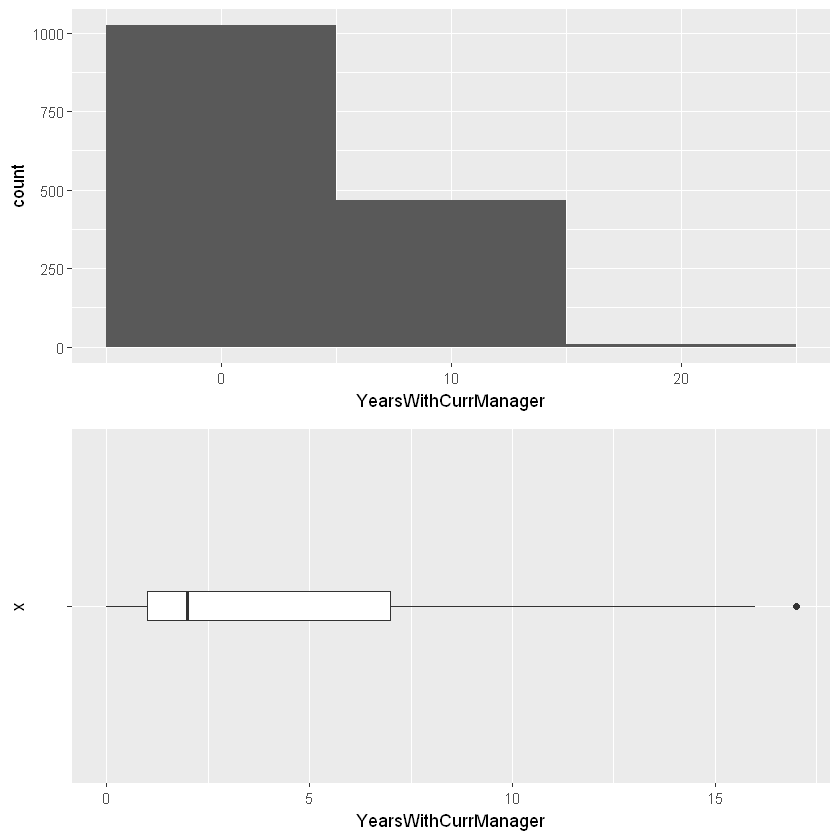

In [46]:
plot_grid(ggplot(hrdata, aes(YearsWithCurrManager))+ geom_histogram(binwidth = 10),ggplot(hrdata, aes(x="",y=YearsWithCurrManager))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

Outliers can be seen in boxplot

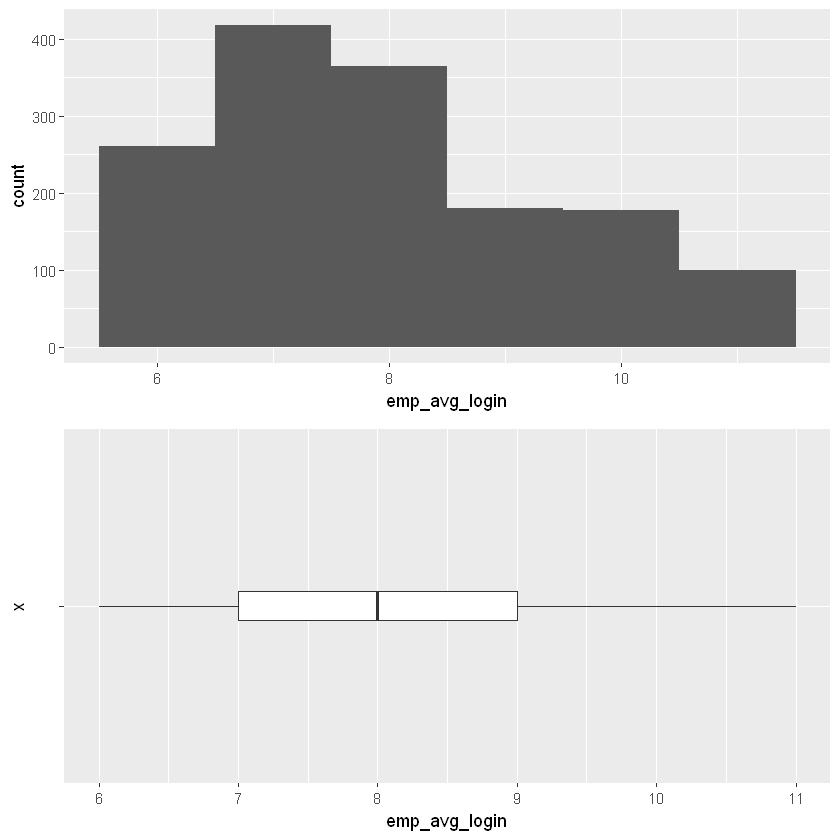

In [47]:
plot_grid(ggplot(hrdata, aes(emp_avg_login))+ geom_histogram(binwidth = 1),ggplot(hrdata, aes(x="",y=emp_avg_login))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

No outliers can be seen in boxplot

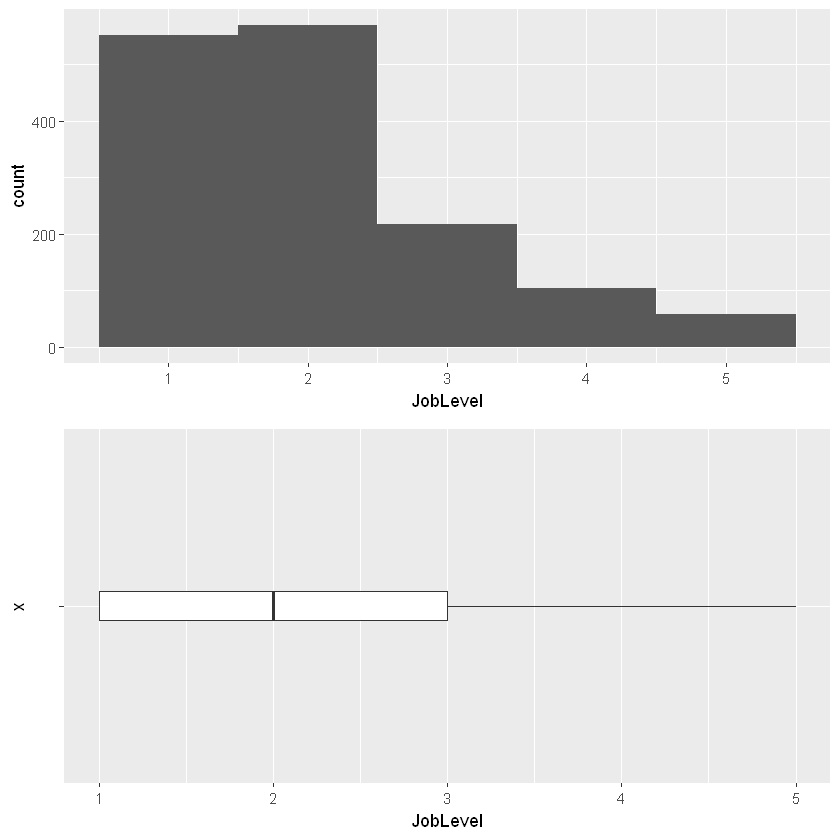

In [48]:
plot_grid(ggplot(hrdata, aes(JobLevel))+ geom_histogram(binwidth = 1),ggplot(hrdata, aes(x="",y=JobLevel))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

No Outliers can be seen in boxplot

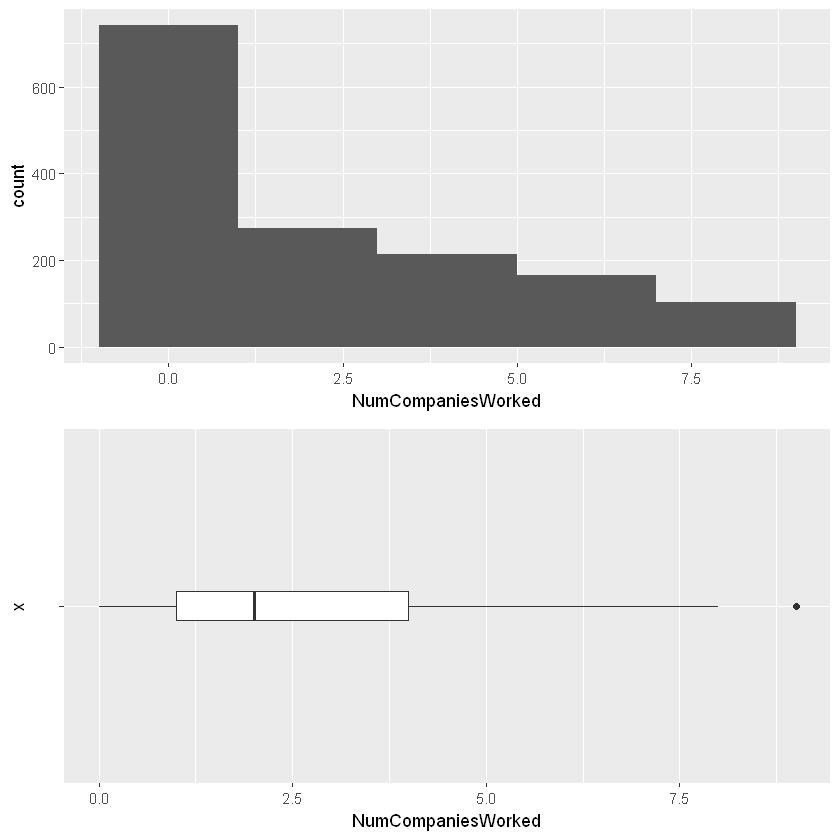

In [49]:
plot_grid(ggplot(hrdata, aes(NumCompaniesWorked))+ geom_histogram(binwidth = 2),ggplot(hrdata, aes(x="",y=NumCompaniesWorked))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

Outliers can be seen in boxplot

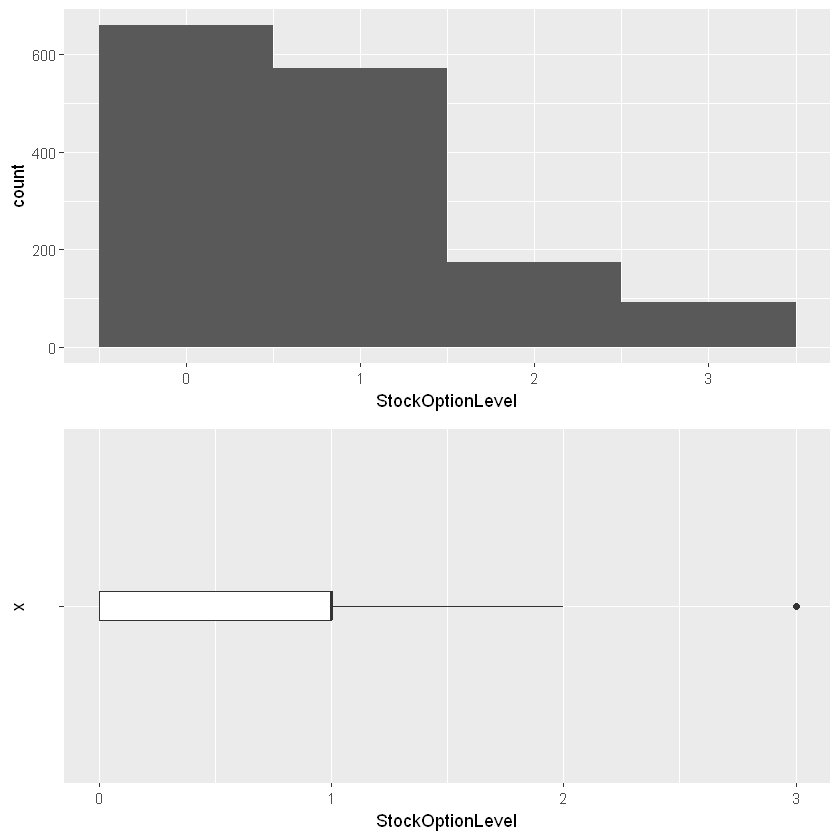

In [50]:
plot_grid(ggplot(hrdata, aes(StockOptionLevel))+ geom_histogram(binwidth = 1),ggplot(hrdata, aes(x="",y=StockOptionLevel))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)

Outliers can be seen in boxplot

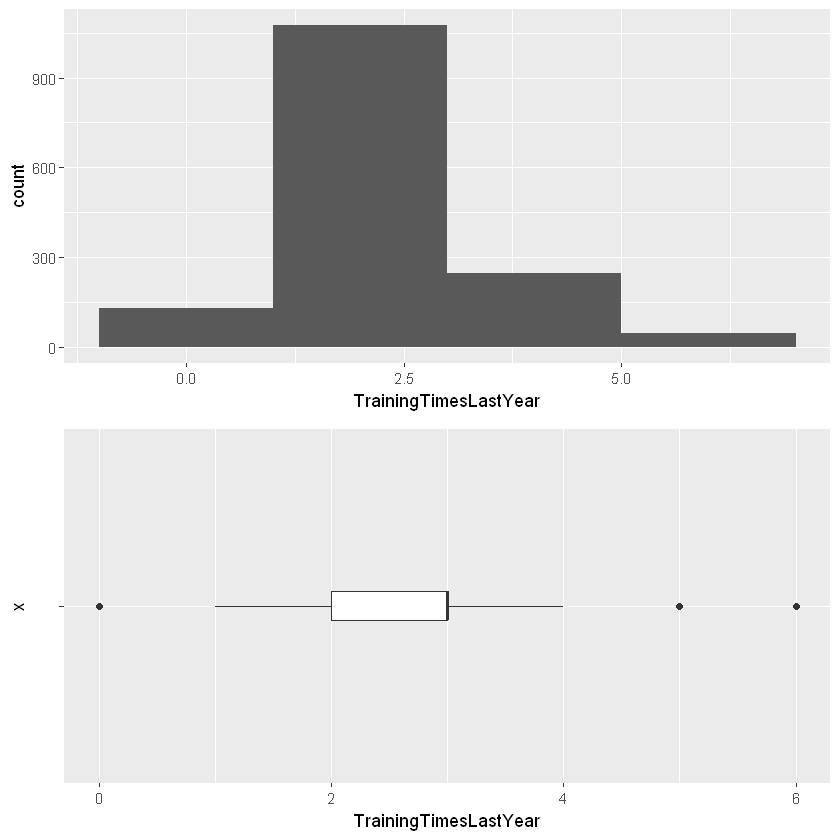

In [51]:
plot_grid(ggplot(hrdata, aes(TrainingTimesLastYear))+ geom_histogram(binwidth = 2),ggplot(hrdata, aes(x="",y=TrainingTimesLastYear))+ geom_boxplot(width=0.1)+coord_flip(), align = "v",ncol = 1)
#Outliers can be seen in boxplot

Outliers can be seen in boxplot

## Outlier treatment

Removing outliers for few variables from the data set as seen from the boxplots.

In [52]:
box <- boxplot.stats(hrdata$YearsAtCompany)
out <- box$out
ad1 <- hrdata[ !hrdata$YearsAtCompany %in% out, ]
hrdata <- ad1
box <- boxplot.stats(hrdata$NumCompaniesWorked)
out <- box$out
ad1 <- hrdata[ !hrdata$NumCompaniesWorked %in% out, ]
hrdata <- ad1
box <- boxplot.stats(hrdata$StockOptionLevel)
out <- box$out
ad1 <- hrdata[ !hrdata$StockOptionLevel %in% out, ]
hrdata <- ad1
box <- boxplot.stats(hrdata$TotalWorkingYears)
out <- box$out
ad1 <- hrdata[ !hrdata$TotalWorkingYears %in% out, ]
hrdata <- ad1
box <- boxplot.stats(hrdata$TrainingTimesLastYear)
out <- box$out
ad1 <- hrdata[ !hrdata$TrainingTimesLastYear %in% out, ]
hrdata <- ad1
box <- boxplot.stats(hrdata$YearsSinceLastPromotion)
out <- box$out
ad1 <- hrdata[ !hrdata$YearsSinceLastPromotion %in% out, ]
hrdata <- ad1
box <- boxplot.stats(hrdata$YearsWithCurrManager)
out <- box$out
ad1 <- hrdata[ !hrdata$YearsWithCurrManager %in% out, ]
hrdata <- ad1

In [53]:
str(hrdata) 

'data.frame':	890 obs. of  28 variables:
 $ EmployeeID             : int  1254 2671 591 2874 330 4134 744 1594 4360 2216 ...
 $ Age                    : int  27 35 35 27 52 38 37 30 36 25 ...
 $ Attrition              : chr  "No" "No" "No" "No" ...
 $ BusinessTravel         : chr  "Travel_Rarely" "Travel_Rarely" "Travel_Frequently" "Travel_Rarely" ...
 $ Department             : chr  "Sales" "Human Resources" "Research & Development" "Sales" ...
 $ DistanceFromHome       : int  8 14 3 15 29 23 20 3 1 1 ...
 $ Education              : chr  "College" "Below College" "Bachelor" "Bachelor" ...
 $ EducationField         : chr  "Marketing" "Life Sciences" "Medical" "Marketing" ...
 $ Gender                 : chr  "Female" "Male" "Female" "Male" ...
 $ JobLevel               : int  3 2 2 1 2 3 2 2 2 2 ...
 $ JobRole                : chr  "Research Scientist" "Research Scientist" "Laboratory Technician" "Research Scientist" ...
 $ MaritalStatus          : chr  "Divorced" "Married" "Married" "S

In [54]:
table(hrdata$Attrition)


 No Yes 
450 440 

## Data preprocessing - 2

In [55]:
#Converting specific columns to factors 
hrdata$EmployeeID<-as.factor(hrdata$EmployeeID)

#Feature scaling
num_var<-sapply(hrdata, is.numeric)
hrdata[num_var]<-lapply(hrdata[num_var], scale)
hrdata$EmployeeID<-as.numeric(hrdata$EmployeeID)


# converting target variable Attrition from No/Yes character to factor with levels 0/1 
hrdata$Attrition<- ifelse(hrdata$Attrition=="Yes",1,0)

# Checking Attrition rate of prospect employee
Attritionrate <- sum(hrdata$Attrition)/nrow(hrdata)
Attritionrate   

[1] 0.494382

49.4% Attrition rate. Hence our data is quite balanced now.

In [56]:
#One hot encoding

#Creating categorical subset from the dataset
Cat_var<- hrdata[, c("Education","BusinessTravel", "EnvironmentSatisfaction", "Department", "EducationField","Gender","JobRole","MaritalStatus", "JobSatisfaction","WorkLifeBalance", "JobInvolvement", "PerformanceRating", "emp_login_cat")]


# converting categorical attributes to factor
hrdata_factor<- data.frame(sapply(Cat_var, function(x) factor(x)))

In [57]:
#creating dummy variables for factor attributes
dummies<- data.frame(sapply(hrdata_factor, function(x) data.frame(model.matrix(~x-1,data =hrdata_factor))))


#combining the final dataset
hrdata<-hrdata[, !(names(hrdata)) %in% c( "Education","BusinessTravel", "EnvironmentSatisfaction", "Department", "EducationField","Gender","JobRole","MaritalStatus",  "JobSatisfaction","WorkLifeBalance", "JobInvolvement", "PerformanceRating", "emp_login_cat","EmployeeID")]

hrdata_final<-cbind(hrdata,dummies)

In [58]:
str(hrdata_final) #2228 obs. of 66 variables

'data.frame':	890 obs. of  66 variables:
 $ Age                               : num [1:890, 1] -0.783 0.121 0.121 -0.783 2.042 ...
  ..- attr(*, "scaled:center")= num 33.9
  ..- attr(*, "scaled:scale")= num 8.85
 $ Attrition                         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DistanceFromHome                  : num [1:890, 1] -0.0777 0.7108 -0.7347 0.8422 2.6818 ...
  ..- attr(*, "scaled:center")= num 8.59
  ..- attr(*, "scaled:scale")= num 7.61
 $ JobLevel                          : num [1:890, 1] 0.8752 -0.0543 -0.0543 -0.9838 -0.0543 ...
  ..- attr(*, "scaled:center")= num 2.06
  ..- attr(*, "scaled:scale")= num 1.08
 $ MonthlyIncome                     : num [1:890, 1] -0.399 0.348 -0.916 -0.535 -0.765 ...
  ..- attr(*, "scaled:center")= num 64096
  ..- attr(*, "scaled:scale")= num 45329
 $ NumCompaniesWorked                : num [1:890, 1] -0.689 -0.689 -0.689 -0.689 2.33 ...
  ..- attr(*, "scaled:center")= num 2.6
  ..- attr(*, "scaled:scale")= num 2.32
 $ PercentSalaryHike

## Pearson's Correlation coefficient

In [59]:
cor.test(hrdata_final$Age,hrdata_final$Attrition, type = "pearson")


	Pearson's product-moment correlation

data:  hrdata_final$Age and hrdata_final$Attrition
t = -7.2108, df = 888, p-value = 1.19e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2963252 -0.1721369
sample estimates:
       cor 
-0.2351907 


In [60]:
res1 <- rcorr(as.matrix(hrdata_final), type = "pearson")

In [61]:
as.matrix(res1[[1]])[, 2]

Age                          Attrition 
                      -0.235190724                        1.000000000 
                  DistanceFromHome                           JobLevel 
                      -0.060290286                       -0.018200130 
                     MonthlyIncome                 NumCompaniesWorked 
                       0.002808603                        0.040717561 
                 PercentSalaryHike                   StockOptionLevel 
                       0.022470081                        0.025642192 
                 TotalWorkingYears              TrainingTimesLastYear 
                      -0.263095621                        0.033172132 
                    YearsAtCompany            YearsSinceLastPromotion 
                      -0.323356330                       -0.100210632 
              YearsWithCurrManager                      emp_avg_login 
                      -0.305767286                        0.237158606 
               Education.xBachelor           Education.xBelow.College 
                      -0.007444335                       -0.035335744 
                Education.xCollege                  Education.xDoctor 
                       0.057876433                        0.020519947 
                 Education.xMaster         BusinessTravel.xNon.Travel 
                      -0.029162075                       -0.063503860 
 BusinessTravel.xTravel_Frequently      BusinessTravel.xTravel_Rarely 
                       0.124474028                       -0.077555656 
     EnvironmentSatisfaction.xHigh       EnvironmentSatisfaction.xLow 
                      -0.015910893                        0.094773891 
   EnvironmentSatisfaction.xMedium EnvironmentSatisfaction.xVery.High 
                       0.008441330                       -0.083243146 
       Department.xHuman.Resources Department.xResearch...Development 
                       0.095108975                        0.017300341 
                 Department.xSales    EducationField.xHuman.Resources 
                      -0.072072366                        0.072584295 
     EducationField.xLife.Sciences          EducationField.xMarketing 
                       0.105050691                       -0.040955291 
           EducationField.xMedical              EducationField.xOther 
                      -0.036068434                       -0.046999723 
  EducationField.xTechnical.Degree                     Gender.xFemale 
                      -0.108131564                       -0.056314423 
                      Gender.xMale JobRole.xHealthcare.Representative 
                       0.056314423                       -0.076981789 
          JobRole.xHuman.Resources     JobRole.xLaboratory.Technician 
                       0.016262833                       -0.033123452 
                  JobRole.xManager    JobRole.xManufacturing.Director 
                      -0.024853541                       -0.009347737 
        JobRole.xResearch.Director        JobRole.xResearch.Scientist 
                       0.031096730                        0.019490750 
          JobRole.xSales.Executive      JobRole.xSales.Representative 
                       0.081427841                       -0.040741086 
           MaritalStatus.xDivorced             MaritalStatus.xMarried 
                      -0.115028534                       -0.159595855 
             MaritalStatus.xSingle              JobSatisfaction.xHigh 
                       0.249247353                        0.024518135 
              JobSatisfaction.xLow            JobSatisfaction.xMedium 
                       0.173746839                       -0.023124865 
        JobSatisfaction.xVery.High               WorkLifeBalance.xBad 
                      -0.168457544                        0.100882978 
             WorkLifeBalance.xBest            WorkLifeBalance.xBetter 
                       0.059424132                       -0.093871686 
             WorkLifeBalance.xGood               JobInv

The following variables show significant negative correlation:

    Age
    TotalWorkingYears
    YearsAtCompany
    YearsSinceLastPromotion
    YearsWithCurrManager
    EducationField.xTechnical.Degree
    MaritalStatus.xDivorced
    MaritalStatus.xMarried
    emp_login_cat.xearly.logout


The following variables show significant positive correlation:

    emp_avg_login
    EducationField.xLife.Sciences
    BusinessTravel.xTravel_Frequently
    MaritalStatus.xSingle
    JobSatisfaction.xLow
    WorkLifeBalance.xBad
    emp_login_cat.xovertime
 
      

## Spearman's Correlation coefficient

In [62]:
res2 <- rcorr(as.matrix(hrdata_final), type = "spearman")

In [63]:
as.matrix(res2[[1]])[, 2]

Age                          Attrition 
                      -0.244853467                        1.000000000 
                  DistanceFromHome                           JobLevel 
                      -0.037941166                       -0.017747906 
                     MonthlyIncome                 NumCompaniesWorked 
                       0.034875144                        0.039064439 
                 PercentSalaryHike                   StockOptionLevel 
                       0.036264124                        0.018909800 
                 TotalWorkingYears              TrainingTimesLastYear 
                      -0.287293706                        0.028156094 
                    YearsAtCompany            YearsSinceLastPromotion 
                      -0.350163111                       -0.072547022 
              YearsWithCurrManager                      emp_avg_login 
                      -0.328579218                        0.245904016 
               Education.xBachelor           Education.xBelow.College 
                      -0.007444335                       -0.035335744 
                Education.xCollege                  Education.xDoctor 
                       0.057876433                        0.020519947 
                 Education.xMaster         BusinessTravel.xNon.Travel 
                      -0.029162075                       -0.063503860 
 BusinessTravel.xTravel_Frequently      BusinessTravel.xTravel_Rarely 
                       0.124474028                       -0.077555656 
     EnvironmentSatisfaction.xHigh       EnvironmentSatisfaction.xLow 
                      -0.015910893                        0.094773891 
   EnvironmentSatisfaction.xMedium EnvironmentSatisfaction.xVery.High 
                       0.008441330                       -0.083243146 
       Department.xHuman.Resources Department.xResearch...Development 
                       0.095108975                        0.017300341 
                 Department.xSales    EducationField.xHuman.Resources 
                      -0.072072366                        0.072584295 
     EducationField.xLife.Sciences          EducationField.xMarketing 
                       0.105050691                       -0.040955291 
           EducationField.xMedical              EducationField.xOther 
                      -0.036068434                       -0.046999723 
  EducationField.xTechnical.Degree                     Gender.xFemale 
                      -0.108131564                       -0.056314423 
                      Gender.xMale JobRole.xHealthcare.Representative 
                       0.056314423                       -0.076981789 
          JobRole.xHuman.Resources     JobRole.xLaboratory.Technician 
                       0.016262833                       -0.033123452 
                  JobRole.xManager    JobRole.xManufacturing.Director 
                      -0.024853541                       -0.009347737 
        JobRole.xResearch.Director        JobRole.xResearch.Scientist 
                       0.031096730                        0.019490750 
          JobRole.xSales.Executive      JobRole.xSales.Representative 
                       0.081427841                       -0.040741086 
           MaritalStatus.xDivorced             MaritalStatus.xMarried 
                      -0.115028534                       -0.159595855 
             MaritalStatus.xSingle              JobSatisfaction.xHigh 
                       0.249247353                        0.024518135 
              JobSatisfaction.xLow            JobSatisfaction.xMedium 
                       0.173746839                       -0.023124865 
        JobSatisfaction.xVery.High               WorkLifeBalance.xBad 
                      -0.168457544                        0.100882978 
             WorkLifeBalance.xBest            WorkLifeBalance.xBetter 
                       0.059424132                       -0.093871686 
             WorkLifeBalance.xGood               JobInv

The following variables show significant negative correlation:

    Age
    TotalWorkingYears
    YearsAtCompany
    YearsSinceLastPromotion
    YearsWithCurrManager
    EducationField.xTechnical.Degree
    MaritalStatus.xDivorced
    MaritalStatus.xMarried
    emp_login_cat.xearly.logout


The following variables show significant positive correlation:

    emp_avg_login
    EducationField.xLife.Sciences
    BusinessTravel.xTravel_Frequently
    MaritalStatus.xSingle
    JobSatisfaction.xLow
    WorkLifeBalance.xBad
    emp_login_cat.xovertime

## Correlation matrix

We plot a correlation matrix of selected variables from the above analysis.

In [64]:
col_names <- c("Age", "TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager", 
               "EducationField.xTechnical.Degree", "MaritalStatus.xDivorced", "MaritalStatus.xMarried",
               "emp_login_cat.xearly.logout", "emp_avg_login","EducationField.xLife.Sciences", "MaritalStatus.xSingle",
               "BusinessTravel.xTravel_Frequently", "JobSatisfaction.xLow", "WorkLifeBalance.xBad", 
               "emp_login_cat.xovertime", "Attrition")
hrdata_new <- hrdata_final[, col_names]
str(hrdata_new)

'data.frame':	890 obs. of  17 variables:
 $ Age                              : num [1:890, 1] -0.783 0.121 0.121 -0.783 2.042 ...
  ..- attr(*, "scaled:center")= num 33.9
  ..- attr(*, "scaled:scale")= num 8.85
 $ TotalWorkingYears                : num [1:890, 1] -1.28 -0.71 -1.09 -0.141 0.238 ...
  ..- attr(*, "scaled:center")= num 7.74
  ..- attr(*, "scaled:scale")= num 5.27
 $ YearsAtCompany                   : num [1:890, 1] -0.9523 -0.0636 -0.6561 0.8251 0.2327 ...
  ..- attr(*, "scaled:center")= num 4.21
  ..- attr(*, "scaled:scale")= num 3.38
 $ YearsSinceLastPromotion          : num [1:890, 1] -0.719 0.181 1.081 -0.719 0.181 ...
  ..- attr(*, "scaled:center")= num 0.799
  ..- attr(*, "scaled:scale")= num 1.11
 $ YearsWithCurrManager             : num [1:890, 1] -0.979 -0.601 -0.223 0.155 0.533 ...
  ..- attr(*, "scaled:center")= num 2.59
  ..- attr(*, "scaled:scale")= num 2.64
 $ EducationField.xTechnical.Degree : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MaritalStatus.xDivorced         

corrplot 0.84 loaded


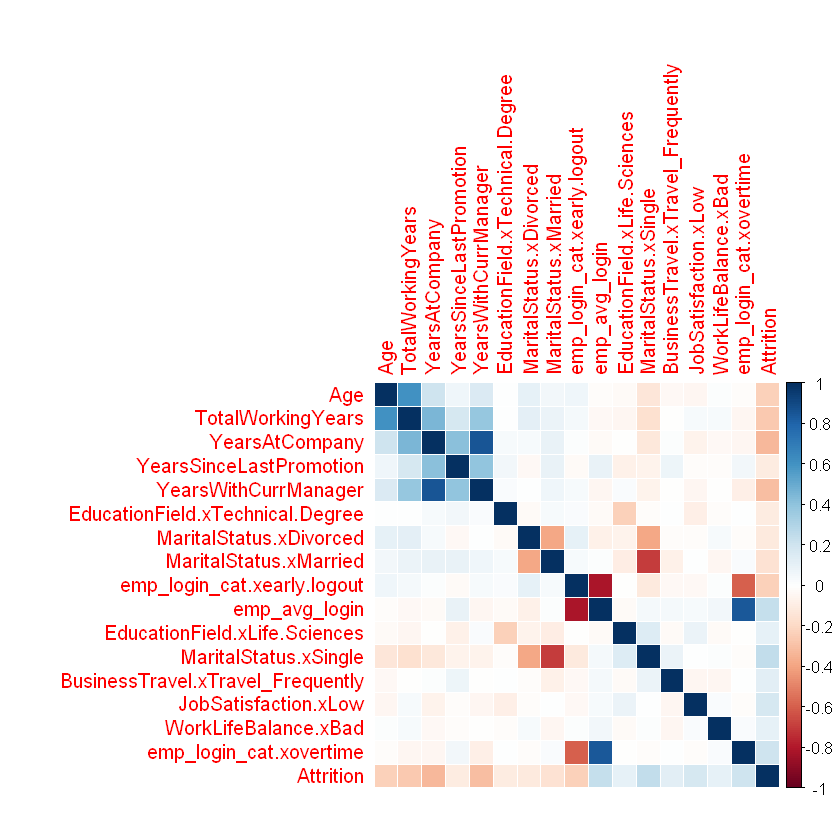

In [65]:
library(corrplot)

corrplot(cor(hrdata_new), method="color", outline="White")

## Regression analysis

Now we do regression analysis on input variables that are highly dependent on each other.


Call:
lm(formula = hrdata_new$Age ~ hrdata_new$TotalWorkingYears)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9503 -0.6908 -0.1327  0.4426  2.9192 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  3.625e-16  2.670e-02    0.00        1    
hrdata_new$TotalWorkingYears 6.051e-01  2.672e-02   22.65   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7966 on 888 degrees of freedom
Multiple R-squared:  0.3661,	Adjusted R-squared:  0.3654 
F-statistic:   513 on 1 and 888 DF,  p-value: < 2.2e-16



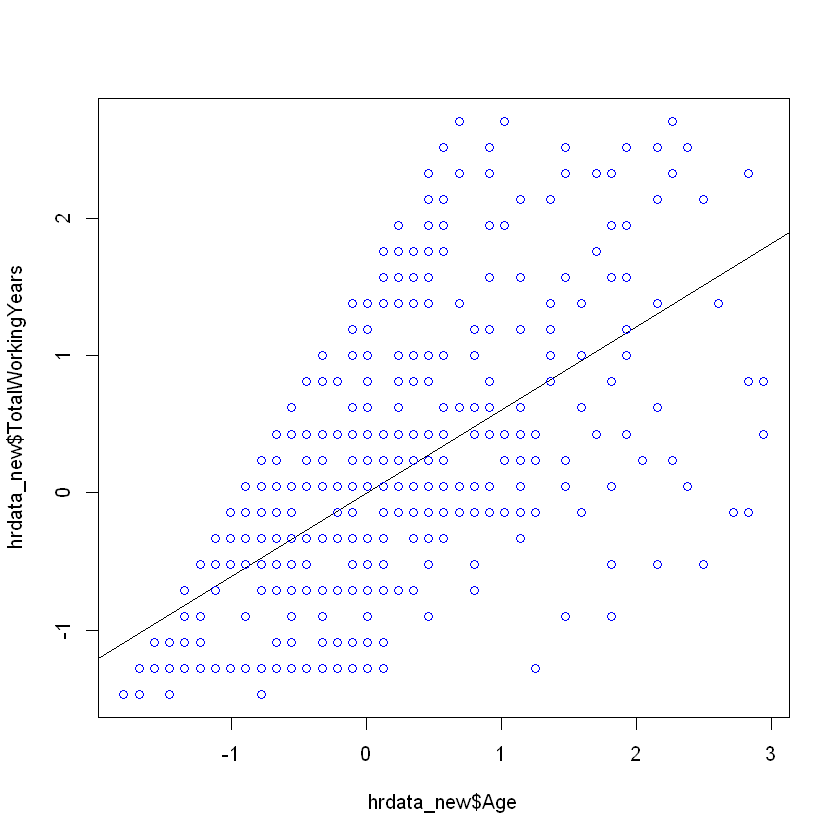

In [66]:
relation <- lm(hrdata_new$Age~hrdata_new$TotalWorkingYears)

print(summary(relation))

# Plot the chart.
plot(hrdata_new$Age,hrdata_new$TotalWorkingYears,col = "blue", abline(relation ,cex = 1.3,pch = 16))

#One of these need to be removed


Call:
lm(formula = hrdata_new$YearsAtCompany ~ hrdata_new$TotalWorkingYears)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1860 -0.4684 -0.1223  0.4702  3.1098 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -3.415e-17  2.985e-02    0.00        1    
hrdata_new$TotalWorkingYears  4.562e-01  2.986e-02   15.28   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8904 on 888 degrees of freedom
Multiple R-squared:  0.2081,	Adjusted R-squared:  0.2072 
F-statistic: 233.4 on 1 and 888 DF,  p-value: < 2.2e-16



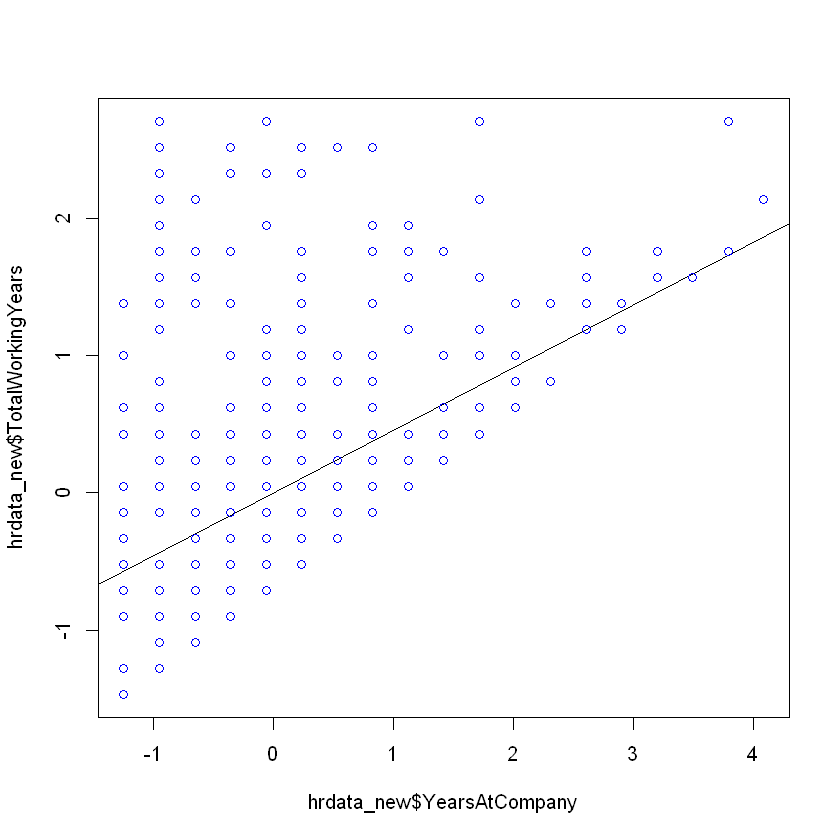

In [67]:
relation <- lm(hrdata_new$YearsAtCompany~hrdata_new$TotalWorkingYears)

print(summary(relation))

# Plot the chart.
plot(hrdata_new$YearsAtCompany,hrdata_new$TotalWorkingYears,col = "blue", abline(relation ,cex = 1.3,pch = 16))



Call:
lm(formula = hrdata_new$YearsWithCurrManager ~ hrdata_new$TotalWorkingYears)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0137 -0.4901 -0.0965  0.3658  2.5663 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.861e-17  3.099e-02    0.00        1    
hrdata_new$TotalWorkingYears 3.824e-01  3.101e-02   12.33   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9245 on 888 degrees of freedom
Multiple R-squared:  0.1463,	Adjusted R-squared:  0.1453 
F-statistic: 152.1 on 1 and 888 DF,  p-value: < 2.2e-16



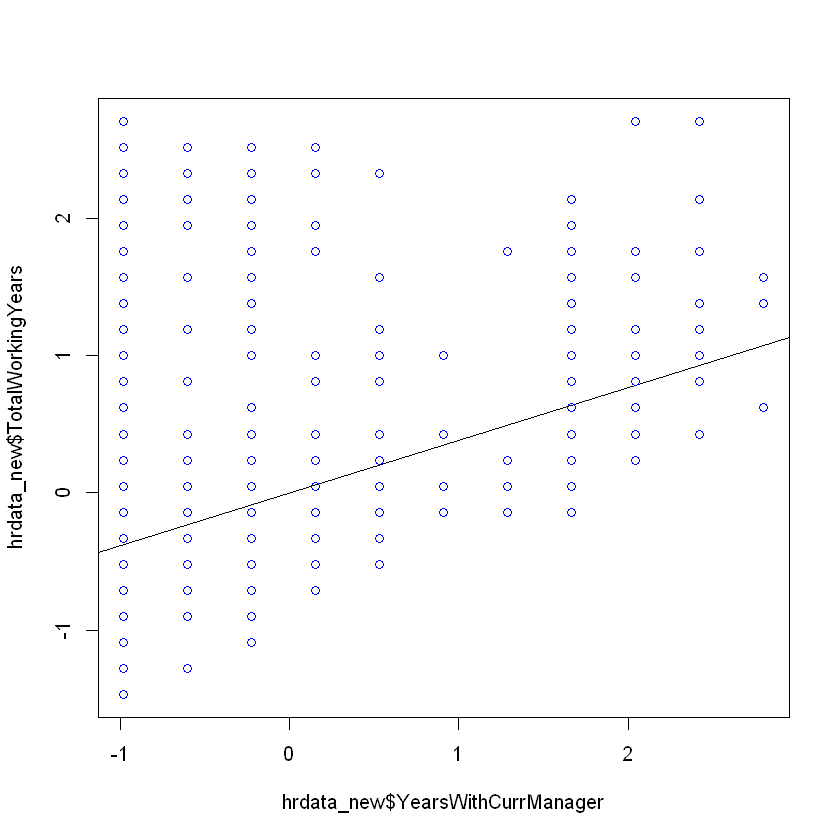

In [68]:
relation <- lm(hrdata_new$YearsWithCurrManager~hrdata_new$TotalWorkingYears)

print(summary(relation))

# Plot the chart.
plot(hrdata_new$YearsWithCurrManager,hrdata_new$TotalWorkingYears,col = "blue", abline(relation ,cex = 1.3,pch = 16))



Call:
lm(formula = hrdata_new$YearsWithCurrManager ~ hrdata_new$YearsAtCompany)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.07471 -0.16695  0.08392  0.33478  1.08737 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               5.354e-17  1.749e-02    0.00        1    
hrdata_new$YearsAtCompany 8.532e-01  1.750e-02   48.76   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5218 on 888 degrees of freedom
Multiple R-squared:  0.728,	Adjusted R-squared:  0.7277 
F-statistic:  2377 on 1 and 888 DF,  p-value: < 2.2e-16



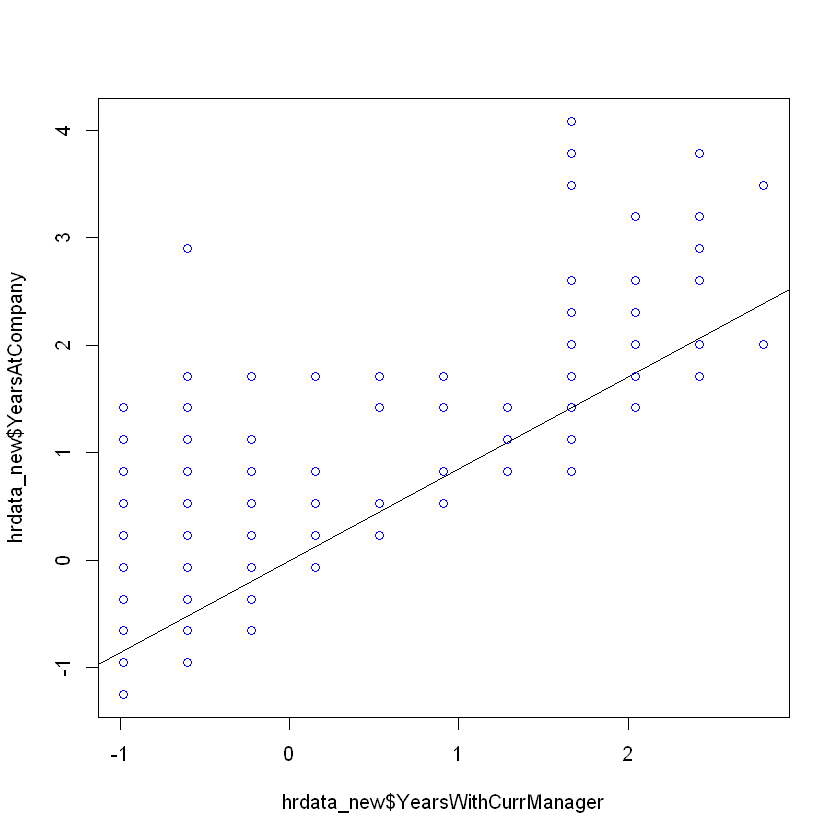

In [69]:
relation <- lm(hrdata_new$YearsWithCurrManager~hrdata_new$YearsAtCompany)

print(summary(relation))

# Plot the chart.
plot(hrdata_new$YearsWithCurrManager,hrdata_new$YearsAtCompany,col = "blue", abline(relation ,cex = 1.3,pch = 16))

#One of these need to be removed


Call:
lm(formula = hrdata_new$YearsSinceLastPromotion ~ hrdata_new$YearsAtCompany)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4381 -0.5682 -0.3197  0.3320  3.4358 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.487e-16  3.045e-02    0.00        1    
hrdata_new$YearsAtCompany 4.195e-01  3.046e-02   13.77   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9083 on 888 degrees of freedom
Multiple R-squared:  0.176,	Adjusted R-squared:  0.175 
F-statistic: 189.6 on 1 and 888 DF,  p-value: < 2.2e-16



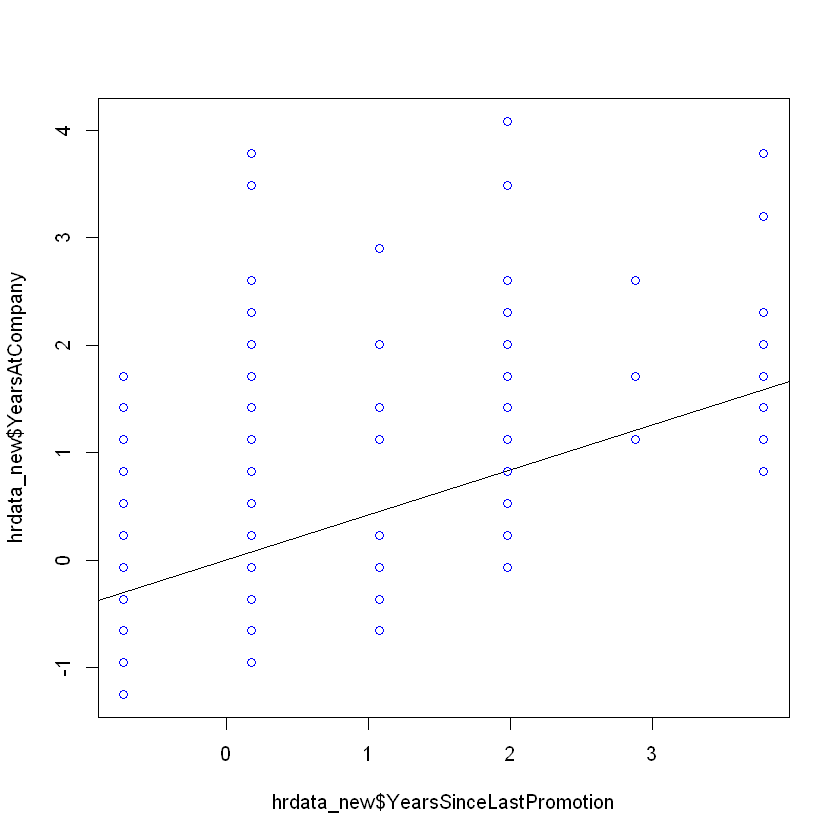

In [70]:
relation <- lm(hrdata_new$YearsSinceLastPromotion~hrdata_new$YearsAtCompany)

print(summary(relation))

# Plot the chart.
plot(hrdata_new$YearsSinceLastPromotion,hrdata_new$YearsAtCompany,col = "blue", abline(relation ,cex = 1.3,pch = 16))


## Final dataset creation

Use 9 dependent variables and split the dataset into test and train wherein 70% is training data.

In [71]:
col_names <- c("TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "MaritalStatus.xDivorced", 
               "emp_login_cat.xearly.logout", "MaritalStatus.xSingle",
               "BusinessTravel.xTravel_Frequently", "JobSatisfaction.xLow", 
               "emp_login_cat.xovertime", "Attrition")
df <- hrdata_new[, col_names]
str(df)

'data.frame':	890 obs. of  10 variables:
 $ TotalWorkingYears                : num [1:890, 1] -1.28 -0.71 -1.09 -0.141 0.238 ...
  ..- attr(*, "scaled:center")= num 7.74
  ..- attr(*, "scaled:scale")= num 5.27
 $ YearsAtCompany                   : num [1:890, 1] -0.9523 -0.0636 -0.6561 0.8251 0.2327 ...
  ..- attr(*, "scaled:center")= num 4.21
  ..- attr(*, "scaled:scale")= num 3.38
 $ YearsSinceLastPromotion          : num [1:890, 1] -0.719 0.181 1.081 -0.719 0.181 ...
  ..- attr(*, "scaled:center")= num 0.799
  ..- attr(*, "scaled:scale")= num 1.11
 $ MaritalStatus.xDivorced          : num  1 0 0 0 0 0 0 0 0 0 ...
 $ emp_login_cat.xearly.logout      : num  0 1 0 0 1 1 0 1 1 0 ...
 $ MaritalStatus.xSingle            : num  0 0 0 1 0 0 1 0 1 0 ...
 $ BusinessTravel.xTravel_Frequently: num  0 0 1 0 0 0 0 0 1 0 ...
 $ JobSatisfaction.xLow             : num  1 0 0 0 0 0 0 0 0 0 ...
 $ emp_login_cat.xovertime          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Attrition                        : num

## Model Building

Using Naive Bayes with 10 fold cross validation.

In [73]:
library(tidyverse) 
library(caret)
library(naivebayes)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x lubridate::as.difftime() masks base::as.difftime()
x lubridate::date()        masks base::date()
x dplyr::filter()          masks stats::filter()
x purrr::flatten()         masks jsonlite::flatten()
x lubridate::intersect()   masks base::intersect()
x dplyr::lag()             masks stats::lag()
x lubridate::setdiff()     masks base::setdiff()
x dplyr::src()             masks Hmisc::src()
x lubridate::stamp()       masks cowplot::stamp()
x dplyr::summarize()       masks Hmisc::summarize()
x lubridate::union()       masks base::union()

Attaching package: 'caret'

The followin

In [79]:
set.seed(100)
trctrl <- trainControl(method = "cv", number = 10, savePredictions=TRUE)
nb_fit <- train(factor(Attrition) ~., data = df, method = "naive_bayes", trControl=trctrl, tuneLength = 0)
nb_fit

Naive Bayes 

890 samples
  9 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 801, 801, 801, 801, 801, 801, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.6741573  0.3486094
   TRUE      0.7067416  0.4123318

Tuning parameter 'laplace' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0, usekernel = TRUE
 and adjust = 1.

In [80]:
pred <- nb_fit$pred
pred$equal <- ifelse(pred$pred == pred$obs, 1,0)

In [81]:
eachfold <- pred %>%                                        
  group_by(Resample) %>%                         
  summarise_at(vars(equal),                     
               list(Accuracy = mean))              
eachfold

Resample,Accuracy
Fold01,0.6179775
Fold02,0.7134831
Fold03,0.7191011
Fold04,0.6966292
Fold05,0.6685393
Fold06,0.7134831
Fold07,0.7247191
Fold08,0.6292135
Fold09,0.6629213
Fold10,0.7584270


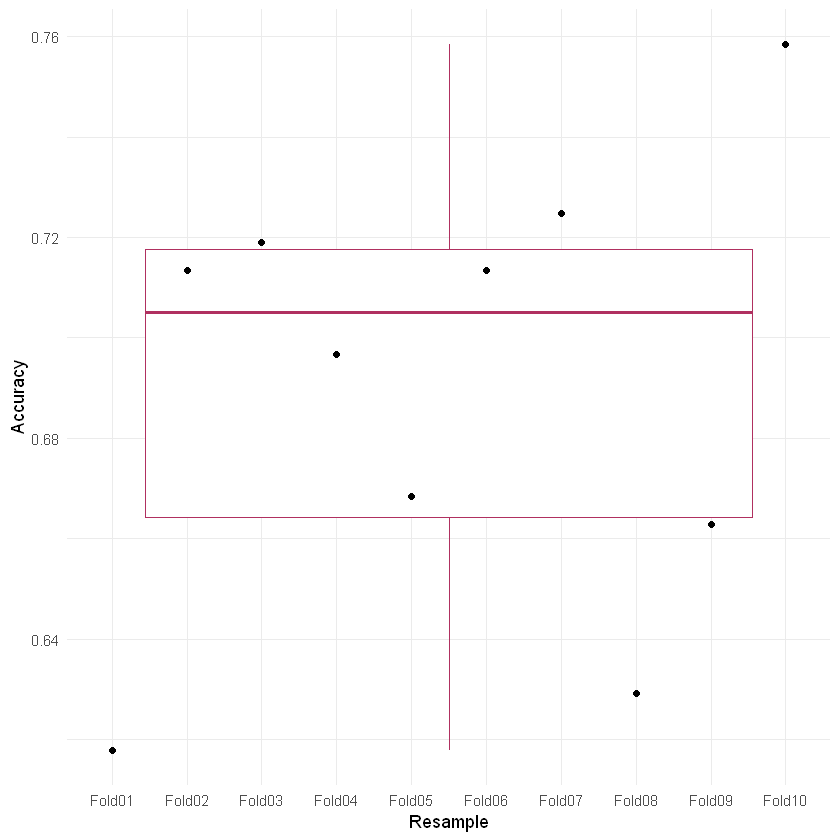

In [82]:
ggplot(data=eachfold, aes(x=Resample, y=Accuracy, group=1)) +
geom_boxplot(color="maroon") +
geom_point() +
theme_minimal()

## Analyse predictions

In [83]:
res <- confusionMatrix(data=pred$pred, reference = pred$obs)

In [84]:
draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'Class1', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'Class2', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'Class1', cex=1.2, srt=90)
  text(140, 335, 'Class2', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)
}  

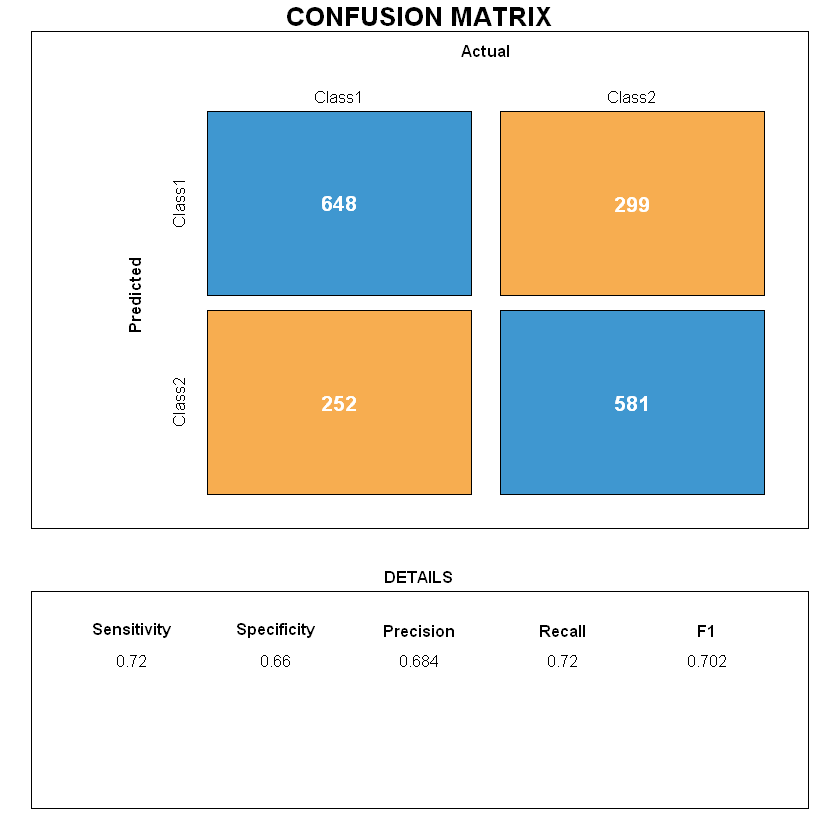

In [85]:
draw_confusion_matrix(res)

In [86]:
as.numeric.factor <- function(x) {as.numeric(levels(x))[x]}

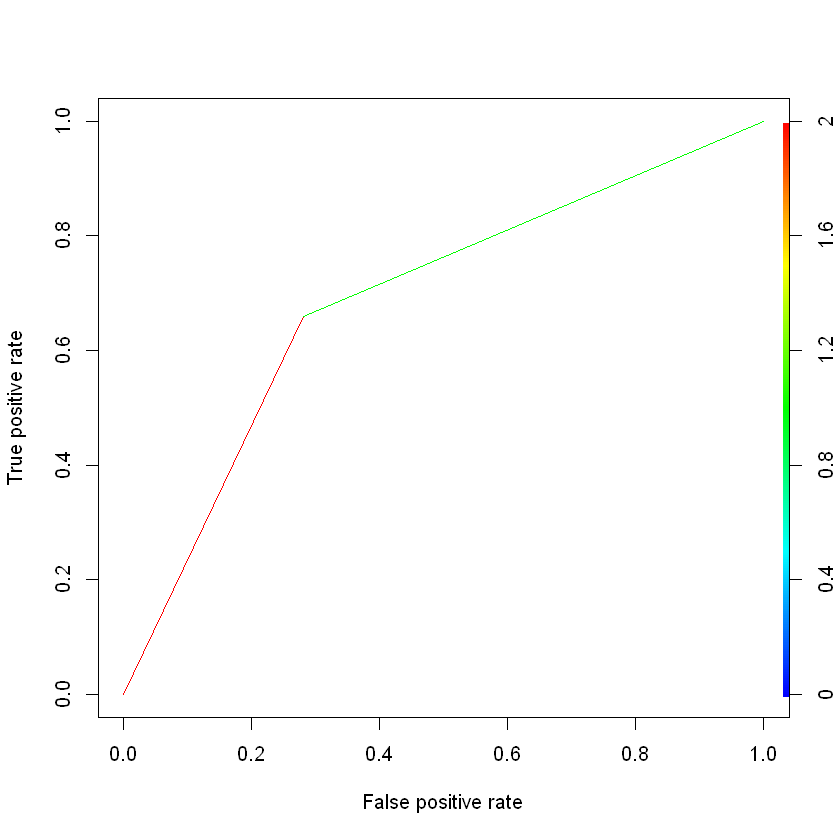

In [87]:
pred <- prediction(as.numeric.factor(pred$pred), as.numeric.factor(pred$obs))
perf <- performance(pred,"tpr","fpr")
plot(perf,colorize=TRUE)